 <div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Airbnb_Logo_B%C3%A9lo.svg/2560px-Airbnb_Logo_B%C3%A9lo.svg.png" width="300">
</div>

<div align="left">

# <span style="color: #ff385c;"> **Análisis de precios de Airbnb en Madrid**</span>


## <span style="color: #ff385c;"> Objetivo del proyecto</span>

A continuación, analizaremos los factores que influyen en los precios de los alojamientos de Airbnb en Madrid, con especial foco en el perfil de propiedades de nuestro cliente.

Realizaremos distintos análisis para averiguar:

- ¿Cuál es el precio óptimo al que debe aspirar nuestro cliente?
- ¿Cómo influye la ubicación en el coste de los alojamientos?
- ¿Qué características de las propiedades tienen mayor impacto en el precio?
- ¿Qué claúsulas afectan al precio?
- ¿Existe una correlación entre las valoraciones de los huéspedes y los precios?
- ¿Qué diferencias hay entre las propiedades de los Superhosts y los anfitriones regulares?


## <span style="color: #ff385c;">Metodología</span>

El proyecto seguirá estos pasos:

1. **Exploración y limpieza de datos**: Análisis de valores nulos, duplicados y outliers
2. **Análisis exploratorio**: Distribución de precios, relaciones entre variables
3. **Análisis estadístico**: Análisis estadístico de las distintas variables
4. **Visualización**: Gráficos para una mejor viasualización del análisis
5. **Conclusiones**: Recomendaciones para optimizar el precio de los apartamentos del cliente
</div>


# <span style="color: #ff385c;"> 0. Librerías</span>

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import os
import kaleido
from IPython.display import Image, display

pio.kaleido.scope.mathjax = None 
import warnings
warnings.simplefilter("ignore")

# Configurar la visualización de DataFrame
pd.set_option('display.max_columns', None)
# Configurar el estilo de las visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
custom_palette = ['#ff385c', '#6a6a6a']
sns.set_palette(custom_palette)

# <span style="color: #ff385c;"> 1. Datos</span>

<div align="left">

El análisis se basa en un conjunto de datos que incluye información sobre más de 21,000 propiedades en Madrid, con detalles sobre:

- **Condiciones**: precio, noches mínimas/máximas, políticas de cancelación
- **Anfitriones**: tiempo de respuesta, tasa de respuesta, estado de Superhost, verificaciones
- **Ubicación**: vecindario, coordenadas, distancia a puntos de interés
- **Propiedades**: tipo de propiedad, tipo de habitación, capacidad, comodidades
- **Reseñas**: puntuaciones, cantidad de reseñas, idiomas de las reseñas

</div>

In [2]:
data_dir = 'data/' 

dataframes = {}

for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_path = os.path.join(data_dir, file)
        df_name = os.path.splitext("df_" + ("".join(list(file.split ("_")[-1]))))[0]
        dataframes[df_name] = pd.read_parquet(file_path)

<div style="text-align: left;">

Los datos están organizados en cinco dataframes:

| Dataframe       | Descripción                            |Filas   |Columnas   |   
|-----------------|----------------------------------------|--------|-----------|
| `df_conditions` | Condiciones de alquiler y precios      | 21,020 | 7         |
| `df_host`       | Información de los anfitriones         | 21,020 | 13        |
| `df_location`   | Datos de ubicación y geografía         | 21,020 | 7         |
| `df_property`   | Características de las propiedades     | 21,020 | 13        |
| `df_reviews`    | Valoraciones y reseñas de huéspedes    | 21,020 | 16        |

</div>

In [3]:
# Definir los dataframes específicos para uso posterior
df_conditions = dataframes['df_conditions']
df_host = dataframes['df_host']
df_location = dataframes['df_location']
df_property = dataframes['df_property']
df_reviews = dataframes['df_reviews']

# Inspección inicial de cada dataframe
print("\n" + "="*50)
print("INSPECCIÓN INICIAL DE DATAFRAMES")
print("="*50)

for name, df in dataframes.items():
    print(f"\n{'-'*40}")
    print(f"Dataframe: {name}")
    print(f"{'-'*40}")
    
    # Forma del dataframe (filas, columnas)
    print(f"Shape: {df.shape} (filas, columnas)")
    
    # Nombres de las columnas
    print(f"\nColumnas: {list(df.columns)}")
    
    # Valores nulos
    null_count = df.isnull().sum()
    print("\nValores nulos por columna:")
    print(null_count[null_count > 0] if null_count.any() > 0 else "No hay valores nulos")
    
    # Duplicados
    duplicates = df.duplicated().sum()
    print(f"\nFilas duplicadas: {duplicates}")
    
    # Posibles columnas de clave (suponiendo que son columnas con valores únicos)
    unique_cols = []
    for col in df.columns:
        if df[col].nunique() == len(df):
            unique_cols.append(col)
    print("\nPosibles columnas clave (valores únicos):", unique_cols if unique_cols else "No se encontraron columnas con valores únicos")
        
print("\n" + "="*50)
print("RESUMEN DE POSIBLES CLAVES PARA MERGE")
print("="*50)
for name, df in dataframes.items():
    unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]
    print(f"{name}: {unique_cols}")


INSPECCIÓN INICIAL DE DATAFRAMES

----------------------------------------
Dataframe: df_conditions
----------------------------------------
Shape: (21020, 7) (filas, columnas)

Columnas: ['id', 'price', 'minimum_nights', 'maximum_nights', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']

Valores nulos por columna:
No hay valores nulos

Filas duplicadas: 0

Posibles columnas clave (valores únicos): ['id']

----------------------------------------
Dataframe: df_host
----------------------------------------
Shape: (21020, 13) (filas, columnas)

Columnas: ['id', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_verifications_email', 'host_verifications_phone', 'host_verifications_reviews', 'host_verifications_facebook', 'host_verifications_government_id', 'calculated_host_listings_count', 'host_seniority']

Valores nulos por columna:
host_response_time    4464
host_response_r

<div align="left">

## <span style="color: #ff385c;">Descripción de los Dataframes</span>

### <span style="color: #ff385c;">df_conditions (21,020 filas, 7 columnas)</span>

Contiene información sobre las condiciones contractuales y precios de los alojamientos.

| Variable                           | Tipo    | Descripción                                       |
|------------------------------------|---------|---------------------------------------------------|
| `id`                               | int64   | Identificador único del alojamiento               |
| `price`                            | float64 | Precio por noche (€)                              |
| `minimum_nights`                   | int64   | Número mínimo de noches requeridas                |
| `maximum_nights`                   | int64   | Número máximo de noches permitidas                |
| `cancellation_policy`              | object  | Política de cancelación                           |
| `require_guest_profile_picture`    | int64   | Si se requiere foto de perfil del huésped (0/1)    |
| `require_guest_phone_verification` | int64   | Si se requiere verificación de teléfono (0/1)     |

**Notas**: No hay valores nulos en este dataframe.

---

### <span style="color: #ff385c;">df_location (21,020 filas, 7 columnas)</span>

Datos de ubicación geográfica y relación con el entorno.

| Variable | Tipo | Descripción |
|----------|------|-------------|
| `id` | int64 | Identificador único del alojamiento |
| `neighbourhood` | object | Barrio (nivel detallado) |
| `neighbourhood_group` | object | Distrito (nivel agregado) |
| `latitude` | float64 | Latitud geográfica |
| `longitude` | float64 | Longitud geográfica |
| `dist_km_sol` | float64 | Distancia en km a la Puerta del Sol |
| `dist_km_airport` | float64 | Distancia en km al aeropuerto |

**Notas**: No hay valores nulos en este dataframe.

---

### <span style="color: #ff385c;">df_property (21,020 filas, 13 columnas)</span>

Características físicas y descriptivas de las propiedades.

| Variable | Tipo | Descripción |
|----------|------|-------------|
| `id` | int64 | Identificador único del alojamiento |
| `property_type` | object | Tipo de propiedad (apartamento, casa, etc.) |
| `room_type` | object | Tipo de habitación (entire_home_apt, private_room, etc.) |
| `accommodates` | int64 | Capacidad máxima de personas |
| `bathrooms` | float64 | Número de baños |
| `bedrooms` | float64 | Número de dormitorios |
| `beds` | float64 | Número de camas |
| `bed_type` | object | Tipo de cama (real_bed, etc.) |
| `amenities_wifi_internet` | int64 | Disponibilidad de WiFi/Internet (0/1) |
| `amenities_tv` | int64 | Disponibilidad de televisión (0/1) |
| `amenities_air_conditioning` | int64 | Disponibilidad de aire acondicionado (0/1) |
| `amenities_heating` | int64 | Disponibilidad de calefacción (0/1) |
| `amenities_kitchen` | int64 | Disponibilidad de cocina (0/1) |

**Notas**: No hay valores nulos en este dataframe.

---

### <span style="color: #ff385c;">df_reviews (21,020 filas, 16 columnas)</span>

Información sobre valoraciones y reseñas de los huéspedes.

| Variable | Tipo | Descripción |
|----------|------|-------------|
| `id` | int64 | Identificador único del alojamiento |
| `number_of_reviews` | int64 | Cantidad total de reseñas |
| `number_of_reviews_ltm` | int64 | Cantidad de reseñas en los últimos 12 meses |
| `review_scores_rating` | float64 | Puntuación general (0-100) |
| `review_scores_accuracy` | float64 | Puntuación en precisión (0-10) |
| `review_scores_cleanliness` | float64 | Puntuación en limpieza (0-10) |
| `review_scores_checkin` | float64 | Puntuación en proceso de check-in (0-10) |
| `review_scores_communication` | float64 | Puntuación en comunicación (0-10) |
| `review_scores_location` | float64 | Puntuación en ubicación (0-10) |
| `review_scores_value` | float64 | Puntuación en relación calidad-precio (0-10) |
| `reviews_per_month` | float64 | Promedio de reseñas por mes |
| `days_since_last_review` | int64 | Días transcurridos desde la última reseña |
| `days_since_first_review` | int64 | Días transcurridos desde la primera reseña |
| `number_of_reviews_en` | float64 | Número de reseñas en inglés |
| `number_of_reviews_es` | float64 | Número de reseñas en español |
| `number_of_reviews_otros` | float64 | Número de reseñas en otros idiomas |

**Notas**: Hay valores nulos considerables en las columnas de puntuaciones (~4,294) y en las columnas relacionadas con reseñas mensuales e idiomas (4,038).

---

### <span style="color: #ff385c;">df_host (21,020 filas, 13 columnas)</span>

Información detallada sobre los anfitriones.

| Variable | Tipo | Descripción |
|----------|------|-------------|
| `id` | int64 | Identificador único del alojamiento |
| `host_response_time` | object | Tiempo promedio de respuesta del anfitrión |
| `host_response_rate` | float64 | Porcentaje de mensajes respondidos |
| `host_is_superhost` | int64 | Si el anfitrión tiene estatus de Superhost (0/1) |
| `host_has_profile_pic` | int64 | Si el anfitrión tiene foto de perfil (0/1) |
| `host_identity_verified` | int64 | Si la identidad del anfitrión está verificada (0/1) |
| `host_verifications_email` | int64 | Si el anfitrión ha verificado su email (0/1) |
| `host_verifications_phone` | int64 | Si el anfitrión ha verificado su teléfono (0/1) |
| `host_verifications_reviews` | int64 | Si el anfitrión ha verificado con reseñas (0/1) |
| `host_verifications_facebook` | int64 | Si el anfitrión ha verificado con Facebook (0/1) |
| `host_verifications_government_id` | int64 | Si el anfitrión ha verificado con identificación oficial (0/1) |
| `calculated_host_listings_count` | int64 | Número total de propiedades del anfitrión |
| `host_seniority` | int64 | Antigüedad del anfitrión en días |

**Notas**: Hay 4,464 valores nulos en `host_response_time` y `host_response_rate`.

</div>

In [4]:
# Merge de todos los dataframes usando la columna 'id'
df = df_conditions.merge(df_host, on='id', how='left')\
                        .merge(df_location, on='id', how='left')\
                        .merge(df_property, on='id', how='left')\
                        .merge(df_reviews, on='id', how='left')

# Verificamos el shape del dataframe resultante
print(f"Shape del dataframe merged: {df.shape}")

# Verificamos que no hemos perdido filas
print(f"Número de filas original: {len(df_conditions)}")
print(f"Número de filas después del merge: {len(df)}")

# Verificamos que tenemos todas las columnas
print(f"Número total de columnas esperadas (sin repetir 'id'): {sum([df_.shape[1] for df_ in dataframes.values()]) - 4*1}")  
print(f"Número de columnas después del merge: {df.shape[1]}")
# Verificamos valores nulos en el dataframe resultante
null_counts = df.isnull().sum()
print("\nValores nulos en el dataframe merged:")
print(null_counts[null_counts > 0])

Shape del dataframe merged: (21020, 52)
Número de filas original: 21020
Número de filas después del merge: 21020
Número total de columnas esperadas (sin repetir 'id'): 52
Número de columnas después del merge: 52

Valores nulos en el dataframe merged:
host_response_time             4464
host_response_rate             4464
review_scores_rating           4294
review_scores_accuracy         4295
review_scores_cleanliness      4293
review_scores_checkin          4292
review_scores_communication    4292
review_scores_location         4295
review_scores_value            4296
reviews_per_month              4038
number_of_reviews_en           4038
number_of_reviews_es           4038
number_of_reviews_otros        4038
dtype: int64


In [5]:
# profile incluida en la carpeta docs
# profile = ProfileReport(df, title="Airbnb_Madrid_Report", explorative=True)
# profile.to_file(os.path.join("..", "docs", "Airbnb_Madrid_Report.html"))

In [6]:
print(f"Columnas numéricas analizadas: {df.select_dtypes(include=['number']).shape[1]}")
display(df.describe())

print(f"\nColumnas categóricas y otras analizadas: {df.select_dtypes(exclude=['number']).shape[1]}")
display(df.describe(include=['O']))


Columnas numéricas analizadas: 45


id         price  minimum_nights  maximum_nights  \
count  21020.000000  21020.000000    21020.000000    2.102000e+04   
mean   10644.643911    131.326213        4.414843    1.276126e+03   
std     6148.700224    364.802634       21.745342    7.664670e+04   
min        0.000000      1.000000        1.000000    1.000000e+00   
25%     5318.750000     40.000000        1.000000    4.000000e+01   
50%    10632.500000     65.000000        2.000000    1.125000e+03   
75%    15965.250000    102.000000        3.000000    1.125000e+03   
max    21365.000000   9999.000000     1125.000000    1.111111e+07   

       require_guest_profile_picture  require_guest_phone_verification  \
count                   21020.000000                      21020.000000   
mean                        0.009420                          0.014891   
std                         0.096599                          0.121118   
min                         0.000000                          0.000000   
25%                         0.000000                          0.000000   
50%                         0.000000                          0.000000   
75%                         0.000000                          0.000000   
max                         1.000000                          1.000000   

       host_response_rate  host_is_superhost  host_has_profile_pic  \
count        16556.000000       21020.000000          21020.000000   
mean            94.249577           0.203330              0.996432   
std             15.582639           0.402486              0.059628   
min              0.000000           0.000000              0.000000   
25%             97.000000           0.000000              1.000000   
50%            100.000000           0.000000              1.000000   
75%            100.000000           0.000000              1.000000   
max            100.000000           1.000000              1.000000   

       host_identity_verified  host_verifications_email  \
count            21020.000000              21020.000000   
mean                 0.299286                  0.936013   
std                  0.457956                  0.244735   
min                  0.000000                  0.000000   
25%                  0.000000                  1.000000   
50%                  0.000000                  1.000000   
75%                  1.000000                  1.000000   
max                  1.000000                  1.000000   

       host_verifications_phone  host_verifications_reviews  \
count              21020.000000                21020.000000   
mean                   0.994291                    0.593815   
std                    0.075343                    0.491131   
min                    0.000000                    0.000000   
25%                    1.000000                    0.000000   
50%                    1.000000                    1.000000   
75%                    1.000000                    1.000000   
max                    1.000000                    1.000000   

       host_verifications_facebook  host_verifications_government_id  \
count                 21020.000000                      21020.000000   
mean                      0.140913                          0.690200   
std                       0.347940                          0.462422   
min                       0.000000                          0.000000   
25%                       0.000000                          0.000000   
50%                       0.000000                          1.000000   
75%                       0.000000                          1.000000   
max                       1.000000                          1.000000   

       calculated_host_listings_count  host_seniority      latitude  \
count                     21020.00000    21020.000000  21020.000000   
mean                         11.54648     1323.182112     40.420573   
std                          32.29336      813.118385      0.021976   
min                           1.00000       -1.000000     40.332


Columnas categóricas y otras analizadas: 7


cancellation_policy host_response_time neighbourhood  \
count                         21020              16556         21020   
unique                            5                  4            66   
top     strict_14_with_grace_period     within_an_hour        Centro   
freq                           7425              12288          5058   

       neighbourhood_group property_type        room_type  bed_type  
count                21020         21020            21020     21020  
unique                  21            30                4         5  
top                 Centro     apartment  entire_home_apt  real_bed  
freq                  9804         17180            12913     20855

# <span style="color: #ff385c;"> 2. Requisitos de cliente</span>

<div align="left">

Nuestro cliente posee este tipo de propiedades por todos los barrios de Madrid y está interesado en optimizar sus tarifas y ampliar su cartera basándose en el análisis

- **Tipo de propiedad**: Apartamentos
- **Localización**: Todos los barrios de Madrid
- **Número de habitaciones**: De 1 a 3 habitaciones
- **Rango de precio**: "no lujo"

</div>

### <span style="color: #ff385c;"> **Apartamentos de 1 a 3 habitaciones**</span>

In [7]:
print(df.shape)
df = df[(df["property_type"] =="apartment") & (df["bedrooms"].between(1, 3))]
df.drop(columns=["property_type"], inplace=True)
print(df.shape)

(21020, 52)
(15651, 51)


In [8]:
print(df[df['room_type'] == 'entire_home_apt'][['id', 'room_type', 'price', 'bedrooms', 'accommodates']].head())
print(df[(df.room_type != 'entire_home_apt') & (df.bedrooms > 1)][['id', 'room_type', 'price', 'bedrooms', 'accommodates']].tail())


   id        room_type  price  bedrooms  accommodates
2   2  entire_home_apt   50.0       3.0             6
4   4  entire_home_apt  115.0       2.0             4
6   6  entire_home_apt   65.0       1.0             2
8   8  entire_home_apt   55.0       1.0             4
9   9  entire_home_apt   90.0       1.0             3
          id     room_type  price  bedrooms  accommodates
20612  20922  private_room  350.0       2.0             2
20625  20937  private_room   35.0       3.0             2
20737  21057  private_room   55.0       2.0             4
20799  21124  private_room   28.0       2.0             4
21012  21357  private_room   28.0       2.0             2


In [9]:
# Se selecciona una propiedad de prueba antes de modificar los precios
id_test = df.loc[
    (df.room_type != 'entire_home_apt') & (df.bedrooms > 1), 
    ["id", "room_type", "bedrooms", "price"]
].head(1) 

if not id_test.empty:
    property_id_test = id_test.iloc[0]["id"]

    print("ANTES de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])

    # Se recalcula el precio de los apartamentos teniendo en cuenta el número de habitaciones 
    mask_room = (df.room_type != 'entire_home_apt') & (df.bedrooms > 1)
    df.loc[mask_room, "price"] = df.loc[mask_room, "price"] * df.loc[mask_room, "bedrooms"]

    print("\nDESPUÉS de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])
else:
    print("No se encontraron propiedades que cumplan la condición.")


ANTES de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0   29.0

DESPUÉS de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0   87.0


In [10]:
print(df[df['room_type'] == 'entire_home_apt'][['id', 'room_type', 'price', 'bedrooms', 'accommodates']].head())
print(df[(df.room_type != 'entire_home_apt') & (df.bedrooms > 1)][['id', 'room_type', 'price', 'bedrooms', 'accommodates']].tail())

   id        room_type  price  bedrooms  accommodates
2   2  entire_home_apt   50.0       3.0             6
4   4  entire_home_apt  115.0       2.0             4
6   6  entire_home_apt   65.0       1.0             2
8   8  entire_home_apt   55.0       1.0             4
9   9  entire_home_apt   90.0       1.0             3
          id     room_type  price  bedrooms  accommodates
20612  20922  private_room  700.0       2.0             2
20625  20937  private_room  105.0       3.0             2
20737  21057  private_room  110.0       2.0             4
20799  21124  private_room   56.0       2.0             4
21012  21357  private_room   56.0       2.0             2


### <span style="color: #ff385c;"> **No lujo**</span>

In [11]:
# Variable de control para ejecutar solo una vez
if "outliers_eliminados" not in globals():
    outliers_eliminados = False

if not outliers_eliminados:
    # Se localizan los outliers y para seleccionar los apartamentos "no lujo" 
    # eliminamos los outliers del límite superior.
    variable_analisis = 'price'
    Q1 = np.percentile(df[variable_analisis], 25)
    Q3 = np.percentile(df[variable_analisis], 75)

    IQR = Q3 - Q1

    print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
    print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
    print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print('\n')
    print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
    print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
    print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
    print('\n')

    # Se eliminan los outliers del límite superior
    df = df[df[variable_analisis] <= limite_superior]

    # Marcar que ya se ejecutó
    outliers_eliminados = True  

    print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
    print(f"Nuevo tamaño del DataFrame: {df.shape}")
else:
    print("⚠️ La eliminación de outliers ya se ejecutó una vez. No se realizará nuevamente.")


Valor del primer cuartil (25%): 40.00
Valor del tercer cuartil (75%): 100.00
Valor del rango intercuartil (IQR): 60.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -50.00
	 - Límite superior (considerado extremadamente alto): 190.00


Se eliminaron los valores mayores a 190.00 en 'price'.
Nuevo tamaño del DataFrame: (14148, 51)


### <span style="color: #ff385c;"> **Optimizar precios**</span>

Calculamos el **precio óptimo** de las viviendas que están en el rango de precios más altos (superior al 90% de los precios). 

In [12]:
# Se crea columna precio_optimo 
umbral_precio_optimo = df["price"].quantile(0.90)
print(f"El umbral de precio óptimo es: {umbral_precio_optimo:.2f}")

df["precio_optimo"] = df["price"] >= umbral_precio_optimo

El umbral de precio óptimo es: 120.00


Calculamos `precio_optimo_huespedes`y vemos cómo influye en el precio la capacidad de huéspedes en el apartamento.

In [13]:
# Agrupar por número de huéspedes y calcular estadísticas
stats_por_huespedes = df.groupby('accommodates')['price'].agg([
    ('precio_medio', 'mean'),
    ('precio_optimo_huespedes', lambda x: np.percentile(x, 90)),
    ('precio_maximo', 'max'),
    ('count', 'count')  # Número de listings por grupo
]).reset_index()

stats_por_huespedes = stats_por_huespedes.round(2)

# Mostrar las estadísticas
print("Estadísticas de precio por número de huéspedes:")
print("\n")
print(stats_por_huespedes)
print("\n")
print(df.shape)
print("\n")
print("Se eliminan registros con más de 12 huéspedes por tener únicamente un caso, lo que impide un análisis estadístico representativo.")
df = df[df['accommodates']<12]
print("\n")
print(df.shape)

Estadísticas de precio por número de huéspedes:


    accommodates  precio_medio  precio_optimo_huespedes  precio_maximo  count
0              1         32.10                     50.0          190.0   1936
1              2         52.32                     95.0          190.0   4532
2              3         69.08                    110.0          180.0   1306
3              4         82.42                    129.0          190.0   3711
4              5         90.27                    135.0          190.0    776
5              6         99.11                    150.0          190.0   1410
6              7        105.82                    160.0          190.0    164
7              8        117.25                    167.7          190.0    252
8              9        114.47                    140.0          175.0     15
9             10        123.21                    167.2          180.0     28
10            11         92.80                    150.0          150.0      5
11            

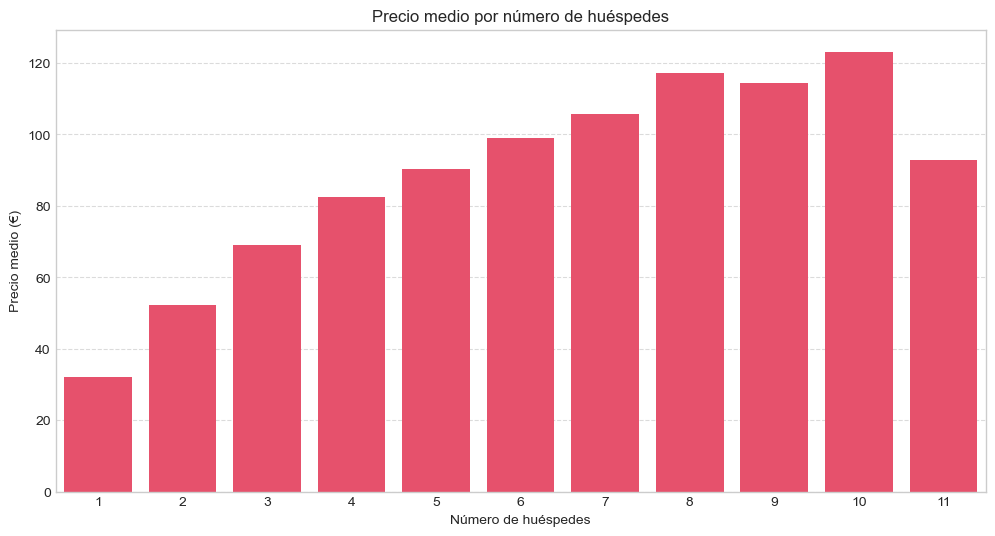

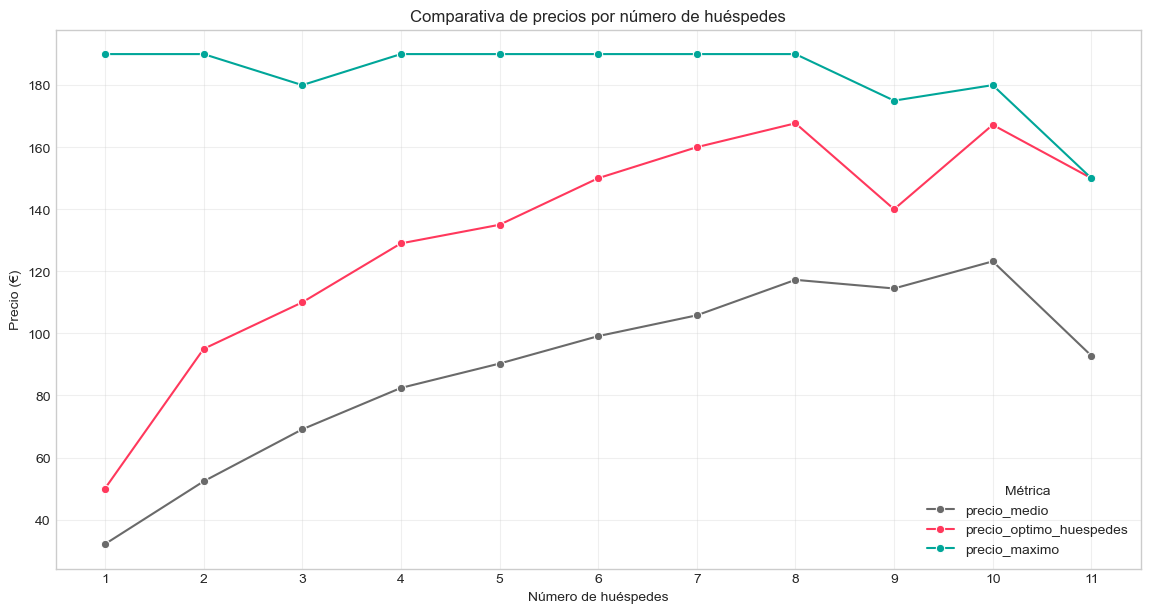

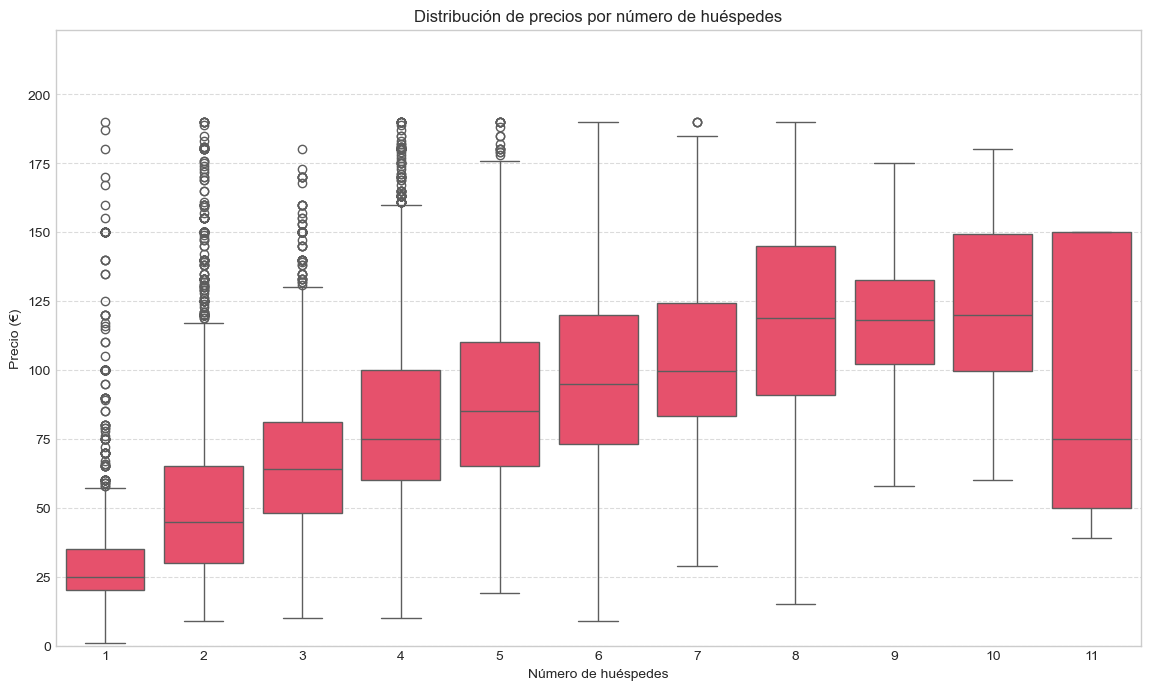

In [14]:
# Agrupar por número de huéspedes y calcular estadísticas
stats_por_huespedes_ = df.groupby('accommodates')['price'].agg([
    ('precio_medio', 'mean'),
    ('precio_optimo_huespedes', lambda x: np.percentile(x, 90)),
    ('precio_maximo', 'max'),
    ('count', 'count')  # Número de listings por grupo
]).reset_index()

stats_por_huespedes_ = stats_por_huespedes_.round(2)


precio_optimo_dict = dict(zip(stats_por_huespedes_['accommodates'], 
                              stats_por_huespedes_['precio_optimo_huespedes']))

# Crear la nueva columna 'precio_optimo_huespedes' 
df['precio_optimo_huespedes'] = df['accommodates'].map(precio_optimo_dict)

# Visualización: Gráfico de barras para precio medio por huéspedes
plt.figure(figsize=(12, 6))
sns.barplot(x='accommodates', y='precio_medio', data=stats_por_huespedes_)
plt.title('Precio medio por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio medio (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualización: Gráfico comparativo de precios
plt.figure(figsize=(14, 7))

# Crear un DataFrame con formato adecuado para seaborn
plot_data = pd.melt(
    stats_por_huespedes_, 
    id_vars=['accommodates'], 
    value_vars=['precio_medio', 'precio_optimo_huespedes', 'precio_maximo'],
    var_name='Métrica',
    value_name='Precio'
)

sns.lineplot(x='accommodates', y='Precio', hue='Métrica', data=plot_data, marker='o', palette=['#6a6a6a', '#ff385c', '#00a699'])
plt.title('Comparativa de precios por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio (€)')
plt.grid(True, alpha=0.3)
plt.xticks(stats_por_huespedes_['accommodates'])
plt.show()

# Análisis adicional: Distribución de precios por número de huéspedes
plt.figure(figsize=(14, 8))
sns.boxplot(x='accommodates', y='price', data=df)
plt.title('Distribución de precios por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, df['price'].quantile(0.95) * 1.5)  # Limitar el eje Y para mejor visualización
plt.show()

In [15]:
# profile incluida en la carpeta docs
# profile = ProfileReport(df, title="Airbnb_Madrid_Report", explorative=True)
# profile.to_file(os.path.join("docs", "Airbnb_Madrid_Report.html"))

# <span style="color: #ff385c;"> 3. Análisis geográfico</span>

In [16]:
#prueba

### Distribución de precios en Madrid

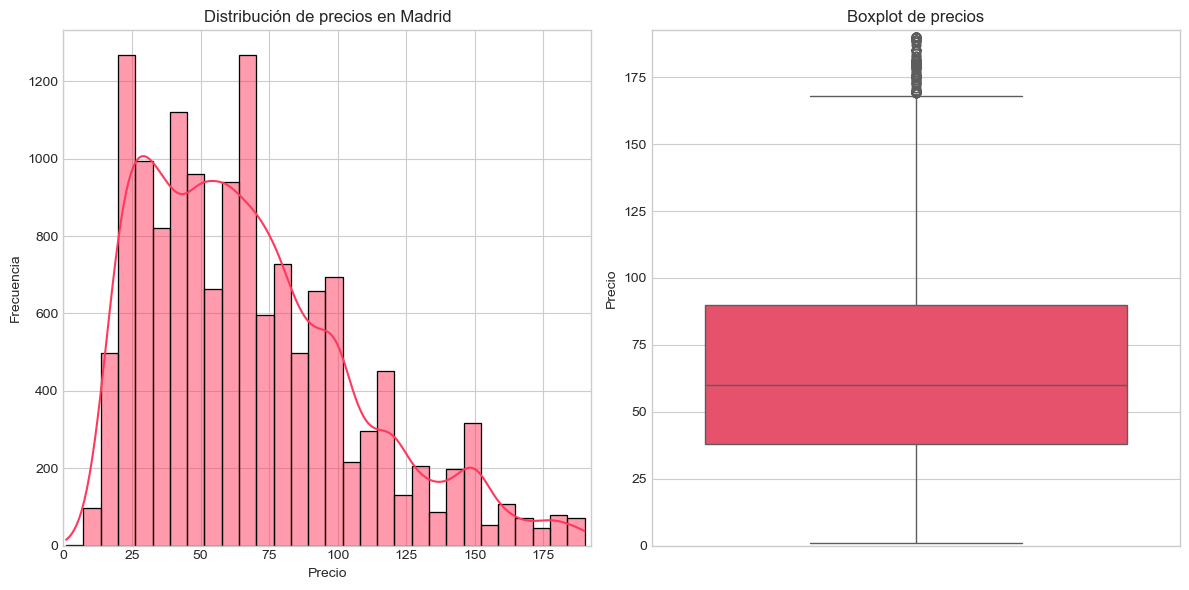

Estadísticas de precios en Madrid:
count    14135.000000
mean        67.753590
std         38.173658
min          1.000000
25%         38.000000
50%         60.000000
75%         90.000000
90%        120.000000
95%        149.000000
max        190.000000
Name: price, dtype: float64


In [17]:
plt.figure(figsize=(12, 6))

# Histograma y boxplot de precios
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribución de precios en Madrid')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.xlim(0, 192.50)  # Establecer límite en el eje x

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Boxplot de precios')
plt.ylabel('Precio')
plt.ylim(0, 192.50)  # Establecer límite en el eje y

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("Estadísticas de precios en Madrid:")
print(df['price'].describe(percentiles=[.25, .5, .75, .9, .95]))

## <span style="color: #ff385c;"> ¿Cómo influye en los precios la distancia a Sol?</span>

### Distribución de precios respecto a la distancia a Sol

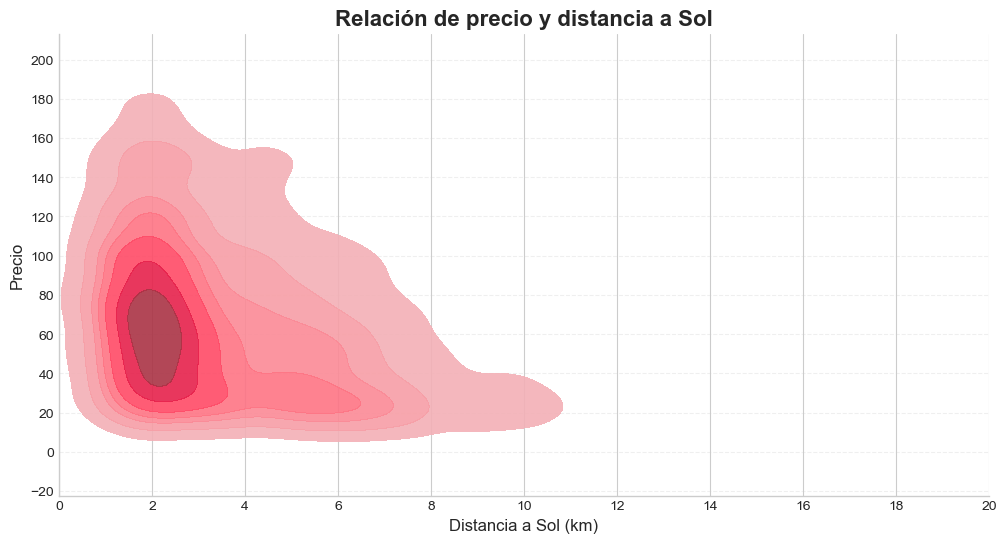

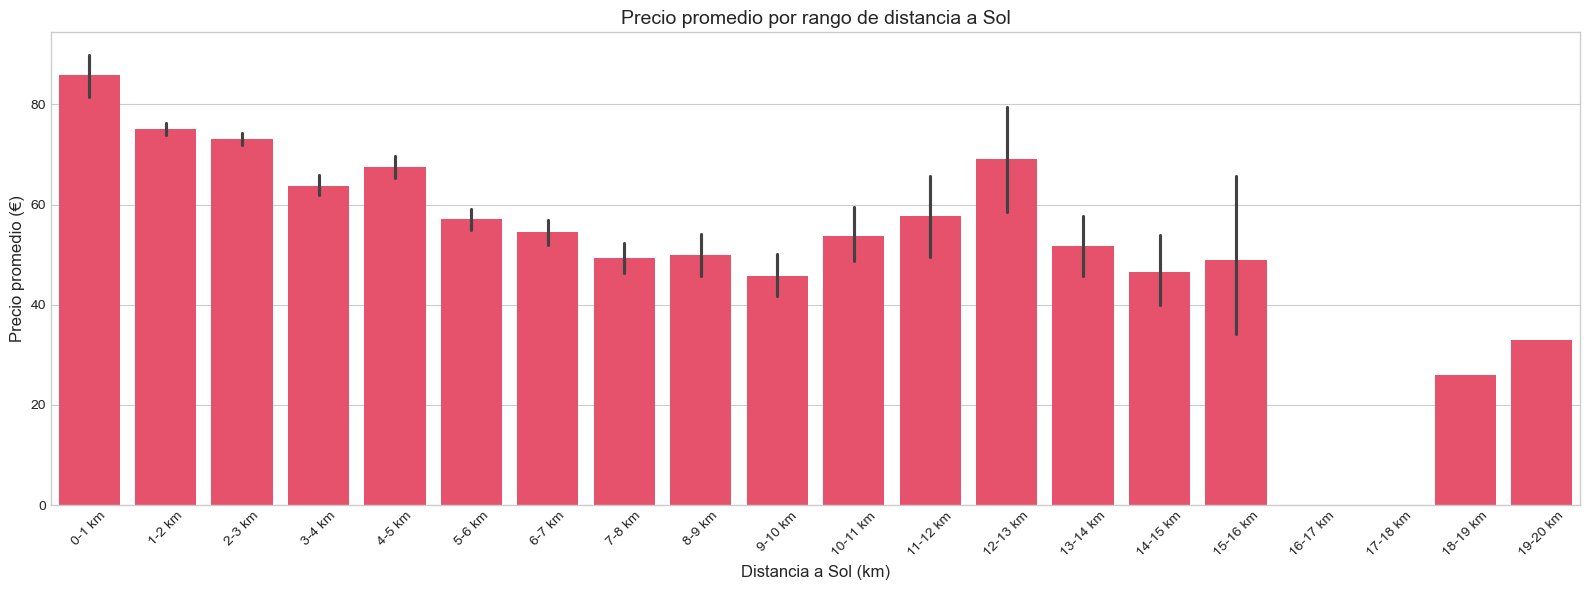

El precio medio en Madrid es: 67.75 €


Distancia a Sol  Precio Medio (€) Comparación con Madrid
0           0-1 km             85.06                  Mayor
1           1-2 km             75.07                  Mayor
2           2-3 km             73.14                  Mayor
3           3-4 km             63.79                  Menor
4           4-5 km             67.47                  Menor
5           5-6 km             57.03                  Menor
6           6-7 km             54.50                  Menor
7           7-8 km             49.35                  Menor
8           8-9 km             50.02                  Menor
9          9-10 km             45.71                  Menor
10        10-11 km             53.78                  Menor
11        11-12 km             57.75                  Menor
12        12-13 km             69.17                  Mayor
13        13-14 km             51.71                  Menor
14        14-15 km             46.44                  Menor
15        15-16 km             48.89                  Menor
18        18-19 km             26.00                  Menor
19        19-20 km             33.00                  Menor

In [18]:
plt.figure(figsize=(12, 6))

# 2D density plot de precio VS distancia en km a Sol
ax = sns.kdeplot(
    data=df,
    x="dist_km_sol",
    y="price",
    fill=True,
    alpha=0.9,
    thresh=0.1,
    levels=8
)

ax.set_title("Relación de precio y distancia a Sol", fontsize=16, fontweight="bold")
ax.set_xlabel("Distancia a Sol (km)", fontsize=12)  
ax.set_ylabel("Precio", fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.grid(alpha=0.3, linestyle="--", axis="y")

ax.set_xlim(0, 20)  # Limitado a 20 km

# Personalizar el marco del plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# 2. Precio promedio por distancia a Sol (agrupado)
# Creamos categorías de distancia 
df['dist_category'] = pd.cut(df['dist_km_sol'],
                           bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                           labels=['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', 
                                  '5-6 km', '6-7 km', '7-8 km', '8-9 km', '9-10 km',
                                  '10-11 km', '11-12 km', '12-13 km', '13-14 km', '14-15 km',
                                  '15-16 km', '16-17 km', '17-18 km', '18-19 km', '19-20 km'])

plt.figure(figsize=(16, 6))
sns.barplot(x='dist_category', y='price', data=df, estimator=np.mean)
plt.title('Precio promedio por rango de distancia a Sol', fontsize=14)
plt.xlabel('Distancia a Sol (km)', fontsize=12)  
plt.ylabel('Precio promedio (€)', fontsize=12)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# Calcular el precio medio en Madrid
precio_medio_madrid = df["price"].mean()

# Definir los rangos de distancia en intervalos de 1 km
bins_km = np.arange(0, df["dist_km_sol"].max() + 1, 1)
distancias_km = [f"{int(bins_km[i])}-{int(bins_km[i+1])} km" for i in range(len(bins_km)-1)]

# Crear columna de clasificación por distancia
df["distancia_a_Sol"] = pd.cut(df["dist_km_sol"], bins=bins_km, labels=distancias_km, right=False)

# Calcular el precio medio por cada rango de distancia
precio_medio_km = df.groupby("distancia_a_Sol")["price"].mean().round(2).reset_index()
precio_medio_km.columns = ["Distancia a Sol", "Precio Medio (€)"]

# Comparar con la media de Madrid
precio_medio_km["Comparación con Madrid"] = precio_medio_km["Precio Medio (€)"].apply(
    lambda x: "Mayor" if x > precio_medio_madrid else "Menor" if x < precio_medio_madrid else "Igual"
)

# Eliminar valores NaN
precio_medio_km = precio_medio_km.dropna()

print(f"El precio medio en Madrid es: {precio_medio_madrid:.2f} €")

precio_medio_km

### Distribución de precios óptimos respecto a la distancia a Sol

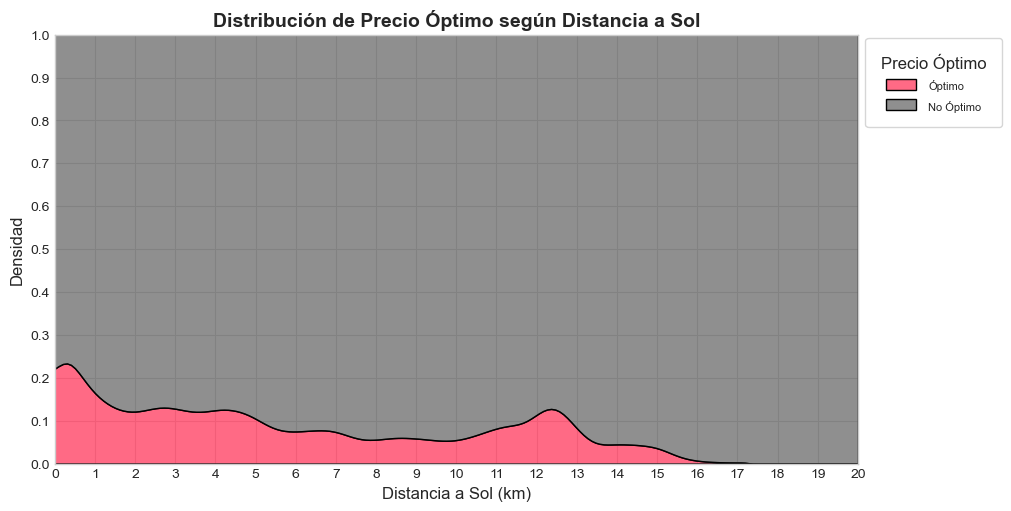

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:
- 2-3 km: 31.12% del total
- 1-2 km: 29.79% del total
- 4-5 km: 10.19% del total


Distancia a Sol % Distribución Óptimos
0           0-1 km                  4.64%
1           1-2 km                 29.79%
2           2-3 km                 31.12%
3           3-4 km                  9.65%
4           4-5 km                 10.19%
5           5-6 km                  5.37%
6           6-7 km                  4.34%
7           7-8 km                  1.27%
8           8-9 km                  0.97%
9          9-10 km                  0.66%
10        10-11 km                  0.72%
11        11-12 km                  0.48%
12        12-13 km                  0.48%
13        13-14 km                  0.12%
14        14-15 km                  0.18%

In [19]:
# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Paleta personalizada
paleta_personalizada = ['#6a6a6a', '#ff385c']

# Gráfico KDE 
sns.kdeplot(
    data=df,
    x="dist_km_sol",
    hue="precio_optimo",
    multiple="fill",
    palette=paleta_personalizada,
    ax=ax,
    clip=(0, 20) 
)

# Títulos y etiquetas
ax.set_title("Distribución de Precio Óptimo según Distancia a Sol", fontsize=14, fontweight="bold")
ax.set_xlabel("Distancia a Sol (km)", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use intervalos de 1 km
ax.set_xticks(np.arange(0, df["dist_km_sol"].max() + 1, 1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Asegurar que el eje X comienza exactamente en 0 y termina en 20 para consistencia
ax.set_xlim(0, 20)

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Calcular el porcentaje de pisos con precio óptimo por rango de distancia
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Calcular el porcentaje de pisos con precio óptimo por rango de distancia
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Distancia a Sol", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar las distancias con mayor concentración de pisos óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Distancia a Sol']}: {row['% Distribución Óptimos']:.2f}% del total")

# Ahora convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios

### Distribución de viviendas en cuanto a capacidad respecto a la distancia a Sol

Tabla completa de viviendas por distancia y capacidad:
accommodates      1     2    3     4    5    6   7    8   9   10  11
distancia_a_Sol                                                     
0-1 km            19    93   35   118   28   62   5   12   1   2   1
1-2 km           229  1094  360  1154  213  469  56  110   8  12   1
2-3 km           356  1241  401  1116  200  376  49   62   3   9   2
3-4 km           278   498  130   354   93  123  16   14   0   1   0
4-5 km           206   418  127   310   87  120  12   15   0   2   0
5-6 km           232   425   83   247   54  109  10   17   2   2   1
6-7 km           205   302   57   176   38   59   6    7   0   0   0
7-8 km           142   135   38    87   11   36   0    8   0   0   0
8-9 km            62    87   22    45   13   13   2    3   0   0   0
9-10 km           89    69   21    33   10   14   1    0   0   0   0
10-11 km          57    64   16    22   17   10   2    2   1   0   0
11-12 km          23    27    6    16    2    7 

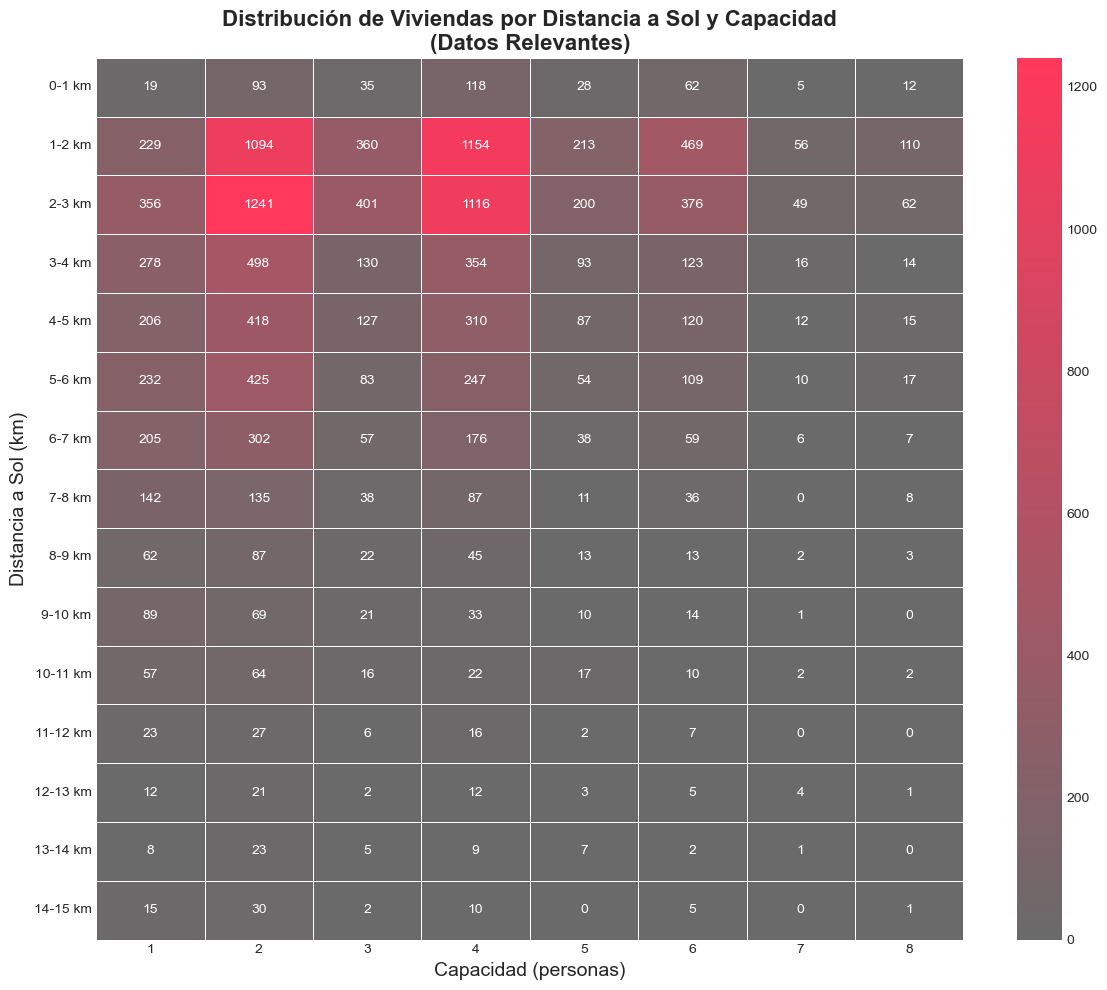


El heatmap muestra 14076 viviendas (99.6% del total)
Se excluyeron 59 viviendas (0.4% del total)


In [20]:
# Crear la tabla cruzada de conteo 
tabla_conteo = pd.pivot_table(df,
                               index='distancia_a_Sol',
                               columns='accommodates',
                               values='precio_optimo',
                               aggfunc='count',
                               fill_value=0)

# Mostrar la tabla completa para examinarla
print("Tabla completa de viviendas por distancia y capacidad:")
print(tabla_conteo)

# Calcular el número total de viviendas
total_viviendas = tabla_conteo.sum().sum()
print(f"\nTotal de viviendas: {total_viviendas}")

# Calcular porcentajes por fila y columna
porcentaje_filas = (tabla_conteo.sum(axis=1) / total_viviendas * 100).round(1)
porcentaje_columnas = (tabla_conteo.sum(axis=0) / total_viviendas * 100).round(1)

print("\nPorcentaje de viviendas por distancia:")
for idx, valor in porcentaje_filas.items():
    print(f"Distancia {idx} km: {valor}% ({tabla_conteo.sum(axis=1)[idx]} viviendas)")

print("\nPorcentaje de viviendas por capacidad:")
for idx, valor in porcentaje_columnas.items():
    print(f"Capacidad {idx} personas: {valor}% ({tabla_conteo.sum(axis=0)[idx]} viviendas)")

# Ajustar umbrales 
umbral_porcentaje_fila = 0.4  # Mantener distancias de 0-15 km (0.4% cubre hasta 14-15 km)
umbral_porcentaje_columna = 1.0  # Aumentar a 1% para eliminar columnas con pocas viviendas

# Filtrar filas y columnas según umbrales
filas_a_mantener = porcentaje_filas[porcentaje_filas >= umbral_porcentaje_fila].index
columnas_a_mantener = porcentaje_columnas[porcentaje_columnas >= umbral_porcentaje_columna].index

tabla_filtrada = tabla_conteo.loc[filas_a_mantener, columnas_a_mantener]

# Crear el heatmap optimizado
plt.figure(figsize=(12, 10))
cmap = LinearSegmentedColormap.from_list("airbnb", ["#6a6a6a", "#ff385c"])
ax = sns.heatmap(tabla_filtrada, annot=True, fmt='d', cmap=cmap, linewidths=0.5)

# Mejorar la presentación
plt.title('Distribución de Viviendas por Distancia a Sol y Capacidad\n(Datos Relevantes)', fontsize=16, fontweight='bold')
plt.ylabel('Distancia a Sol (km)', fontsize=14)
plt.xlabel('Capacidad (personas)', fontsize=14)

# Ajustar etiquetas para mayor claridad
plt.tight_layout()
plt.show()

# Mostrar resumen de datos incluidos vs excluidos
viviendas_incluidas = tabla_filtrada.sum().sum()
porcentaje_incluido = (viviendas_incluidas / total_viviendas) * 100
print(f"\nEl heatmap muestra {viviendas_incluidas} viviendas ({porcentaje_incluido:.1f}% del total)")
print(f"Se excluyeron {total_viviendas - viviendas_incluidas} viviendas ({100 - porcentaje_incluido:.1f}% del total)")

### Distribución de precios óptimos en cuanto a capacidad respecto a la distancia a Sol

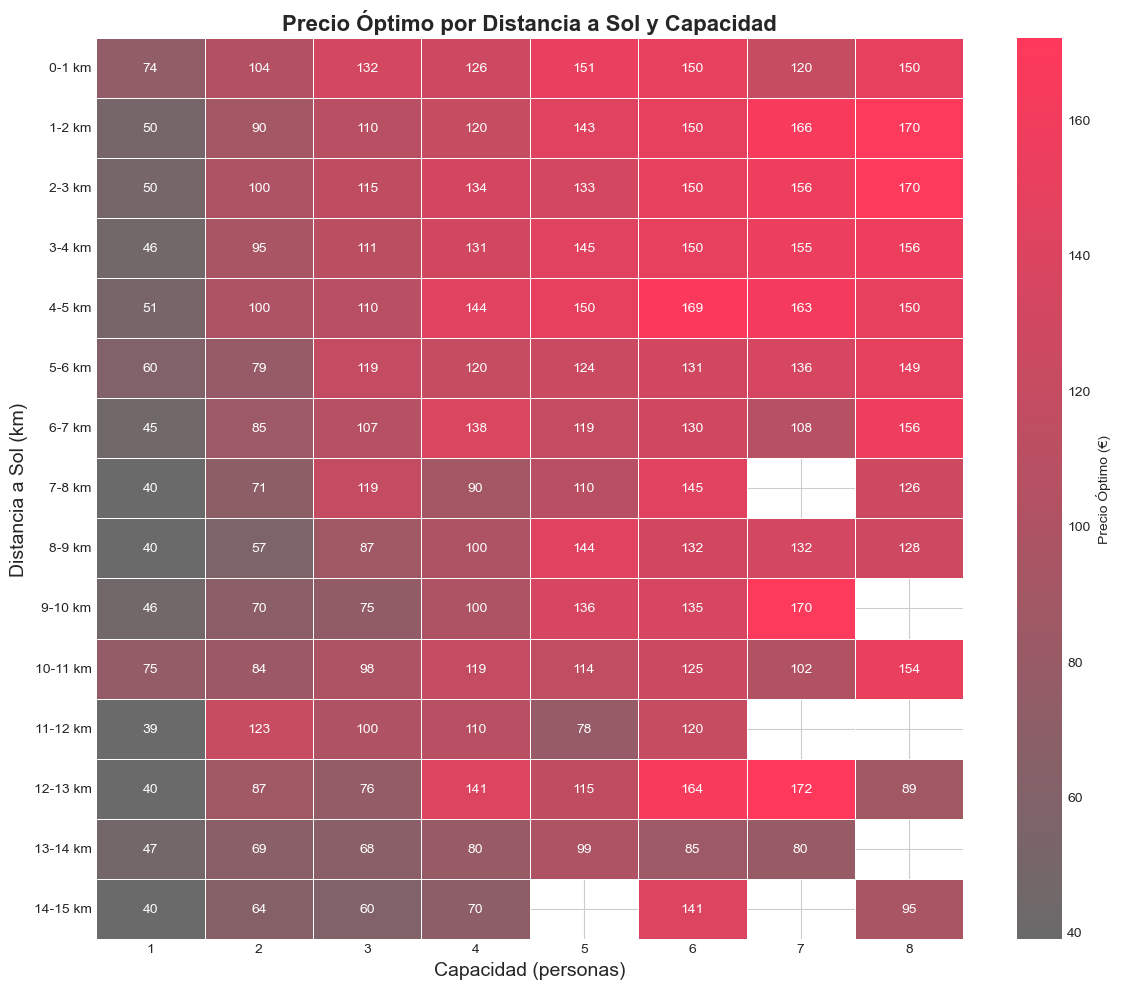


Tabla de Precios Óptimos Máximos por Capacidad:
          Distancia con precio máximo  Precio Óptimo máximo (€)
Capacidad                                                      
1                            10-11 km                      75.4
2                            11-12 km                     122.6
3                              0-1 km                     132.0
4                              4-5 km                     144.1
5                              0-1 km                     151.2
6                              4-5 km                     169.1
7                            12-13 km                     172.0
8                              1-2 km                     170.0


In [21]:
# Crear tabla cruzada con el percentil 90 del precio por grupo
tabla_precios = pd.pivot_table(df,
                               index='distancia_a_Sol',
                               columns='accommodates',
                               values='price',
                               aggfunc=lambda x: np.percentile(x, 90),  # Usar percentil 90
                               fill_value=np.nan)  # Usar NaN para valores vacíos

# Ajustar umbrales adecuados
umbral_porcentaje_fila = 0.4  # Mantener distancias de 0-15 km (0.4% cubre hasta 14-15 km)
umbral_porcentaje_columna = 1.0  # Mantener capacidades que representen al menos 1% del total

# Calcular porcentajes por fila y columna
porcentaje_filas = (tabla_conteo.sum(axis=1) / total_viviendas * 100).round(1)
porcentaje_columnas = (tabla_conteo.sum(axis=0) / total_viviendas * 100).round(1)

# Filtrar filas y columnas según umbrales
filas_a_mantener = porcentaje_filas[porcentaje_filas >= umbral_porcentaje_fila].index
columnas_a_mantener = porcentaje_columnas[porcentaje_columnas >= umbral_porcentaje_columna].index

tabla_filtrada_precios = tabla_precios.loc[filas_a_mantener, columnas_a_mantener]

# Crear el heatmap de precios óptimos
plt.figure(figsize=(12, 10))
cmap = LinearSegmentedColormap.from_list("airbnb", ["#6a6a6a", "#ff385c"])
ax = sns.heatmap(tabla_filtrada_precios, annot=True, fmt='.0f', cmap=cmap, linewidths=0.5, 
                cbar_kws={'label': 'Precio Óptimo (€)'})

plt.title('Precio Óptimo por Distancia a Sol y Capacidad', 
          fontsize=16, fontweight='bold')
plt.ylabel('Distancia a Sol (km)', fontsize=14)
plt.xlabel('Capacidad (personas)', fontsize=14)
plt.tight_layout()
plt.show()

# Crear tabla que muestre dónde está el precio óptimo más alto para cada capacidad
# Encontrar en qué distancia está el precio óptimo más alto para cada capacidad
precios_max_por_capacidad = {}
distancias_max_por_capacidad = {}

for capacidad in columnas_a_mantener:
    if capacidad in tabla_filtrada_precios.columns:
        # Encontrar la distancia con el precio máximo para esta capacidad
        idx_max = tabla_filtrada_precios[capacidad].idxmax()
        precio_max = tabla_filtrada_precios.loc[idx_max, capacidad]
        
        precios_max_por_capacidad[capacidad] = precio_max
        distancias_max_por_capacidad[capacidad] = idx_max

# Crear DataFrame para mostrar la tabla
tabla_precios_maximos = pd.DataFrame({
    'Capacidad': list(precios_max_por_capacidad.keys()),
    'Distancia con precio máximo': list(distancias_max_por_capacidad.values()),
    'Precio Óptimo máximo (€)': list(precios_max_por_capacidad.values())
})

# Establecer Capacidad como índice
tabla_precios_maximos = tabla_precios_maximos.set_index('Capacidad')
tabla_precios_maximos = tabla_precios_maximos.sort_index()

# Mostrar la tabla
print("\nTabla de Precios Óptimos Máximos por Capacidad:")
print(tabla_precios_maximos)

## <span style="color: #ff385c;"> ¿Cómo varía el precio según el barrio?</span>

### Distribución de precios según barrio

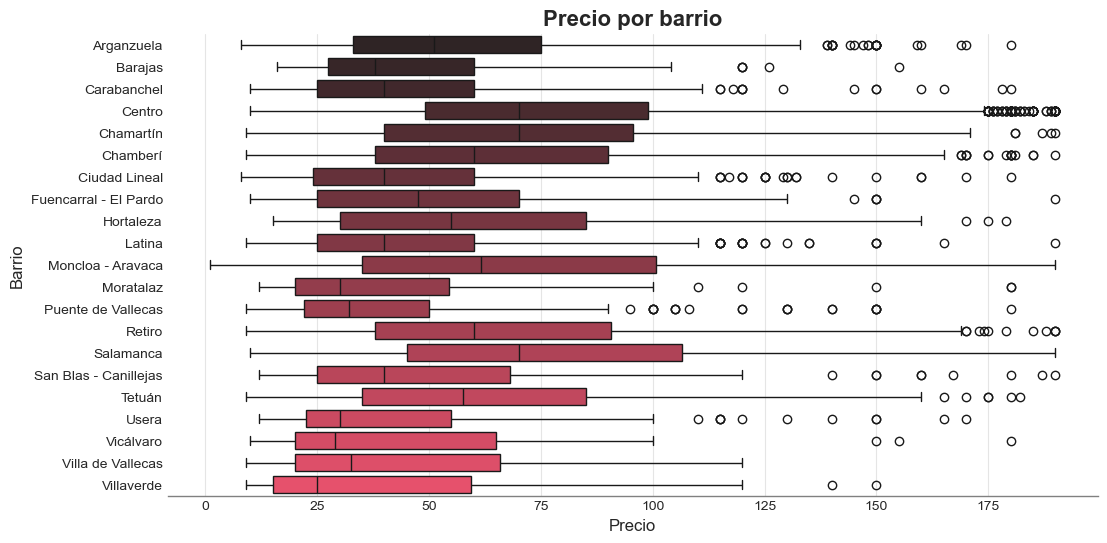

In [22]:
plt.figure(figsize=(12, 6))
# boxplot precio por barrio
ax = sns.boxplot(
    data=df.sort_values("neighbourhood_group"),
    x="price",
    y="neighbourhood_group",
    hue="neighbourhood_group", 
    color= '#ff385c'
)
# añadir título al plot y a los ejes
ax.set_title("Precio por barrio", fontsize=16, fontweight="bold")
ax.set_xlabel("Precio", fontsize=12)
ax.set_ylabel("Barrio", fontsize=12)
# personalizar el grid de fondo
ax.grid(alpha=0.5, drawstyle="steps", axis="x", linestyle="-")
# personalizar el marco del plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("gray")
# show plot
plt.show()

### Comparación de precio óptimo por barrio respecto a precio óptimo de Madrid

In [23]:
# Definir precios
def precio_optimo_barrio(val):
    return val.quantile(0.90)

def precio_median_barrio(val):
    return val.median()
df_barrio_statistics = df.groupby("neighbourhood_group").agg({
    "price": [("Precio Medio", lambda x: x.mean().round(2)),  
              ("Precio Óptimo Barrio", precio_optimo_barrio)],
    "dist_km_sol": [("Distancia Mínima", lambda x: round(x.min(), 1)),  
                    ("Distancia Máxima", lambda x: round(x.max(), 1))]
}).sort_values(("price", "Precio Óptimo Barrio"), ascending=False)

df_barrio_statistics

price                           dist_km_sol  \
                      Precio Medio Precio Óptimo Barrio Distancia Mínima   
neighbourhood_group                                                        
Salamanca                    79.30                150.0              2.8   
Moncloa - Aravaca            74.37                148.5              1.7   
Chamartín                    73.09                130.0              4.4   
Centro                       75.52                127.0              0.0   
Hortaleza                    62.84                126.0              8.7   
Retiro                       69.03                125.0              2.3   
Chamberí                     67.42                120.0              2.4   
Tetuán                       64.43                120.0              4.3   
Vicálvaro                    49.24                110.0              8.9   
San Blas - Canillejas        51.57                100.0              7.9   
Arganzuela                   57.63                100.0              1.7   
Fuencarral - El Pardo        53.48                 96.2              7.6   
Barajas                      47.51                 94.4             12.2   
Ciudad Lineal                47.18                 90.0              5.8   
Moratalaz                    44.45                 89.6              5.7   
Usera                        43.17                 89.0              3.8   
Villa de Vallecas            44.42                 88.1              9.3   
Carabanchel                  47.31                 85.0              3.1   
Latina                       46.60                 80.0              2.2   
Villaverde                   37.49                 78.2              7.6   
Puente de Vallecas           40.76                 70.0              4.7   

                                        
                      Distancia Máxima  
neighbourhood_group                     
Salamanca                          8.1  
Moncloa - Aravaca                 14.3  
Chamartín                         11.2  
Centro                             3.4  
Hortaleza                         15.3  
Retiro                             5.4  
Chamberí                           5.0  
Tetuán                             7.8  
Vicálvaro                         19.0  
San Blas - Canillejas             15.1  
Arganzuela                         5.0  
Fuencarral - El Pardo             13.8  
Barajas                           19.4  
Ciudad Lineal                     10.6  
Moratalaz                          8.6  
Usera                              7.8  
Villa de Vallecas                 14.0  
Carabanchel                       12.2  
Latina                             9.6  
Villaverde                        11.8  
Puente de Vallecas                10.5

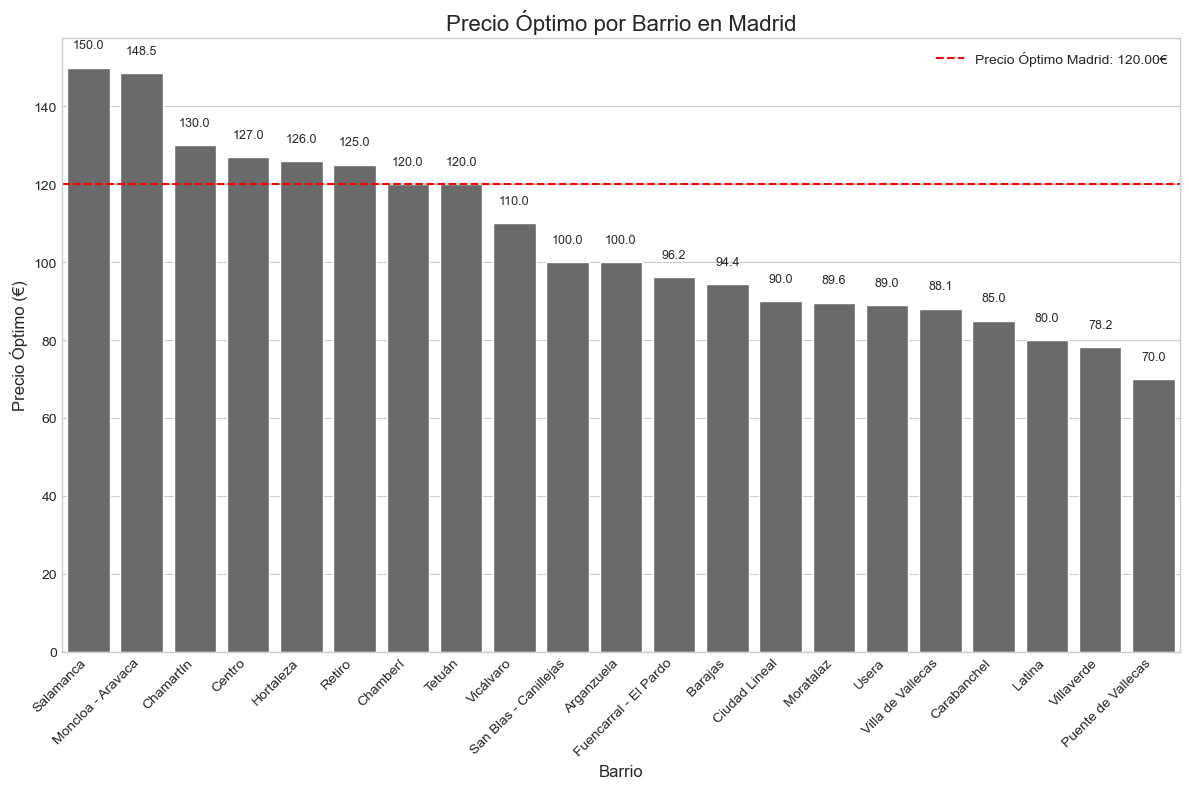

Barrios con precio óptimo por encima del precio óptimo de Madrid:
Salamanca, Moncloa - Aravaca, Chamartín, Centro, Hortaleza, Retiro


In [24]:
#Visualización del gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Extraemos directamente los datos para el gráfico
barrios = df_barrio_statistics.index
precios_optimos = df_barrio_statistics[('price', 'Precio Óptimo Barrio')]

# Creamos el gráfico de barras
ax = sns.barplot(x=barrios, y=precios_optimos, color= '#6a6a6a')

# Añadimos la línea de referencia para el precio óptimo de Madrid
plt.axhline(y=umbral_precio_optimo, color='r', linestyle='--', 
            label=f'Precio Óptimo Madrid: {umbral_precio_optimo:.2f}€')

# Configuramos el gráfico
plt.title('Precio Óptimo por Barrio en Madrid', fontsize=16)
plt.xlabel('Barrio', fontsize=12)
plt.ylabel('Precio Óptimo (€)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()

# Añadimos los valores en las barras
for i, v in enumerate(precios_optimos):
    ax.text(i, v + 5, f'{v:.1f}', ha='center', fontsize=9)

plt.show()

# Mostramos qué barrios están por encima del precio óptimo de Madrid
print("Barrios con precio óptimo por encima del precio óptimo de Madrid:")
barrios_sobre_media = df_barrio_statistics[df_barrio_statistics[('price', 'Precio Óptimo Barrio')] > umbral_precio_optimo].index.tolist()
print(", ".join(barrios_sobre_media))


# <span style="color: #ff385c;"> 4. Análisis inmueble</span> 

## <span style="color: #ff385c;"> ¿Qué características tienen los pisos con precios óptimos?</span>

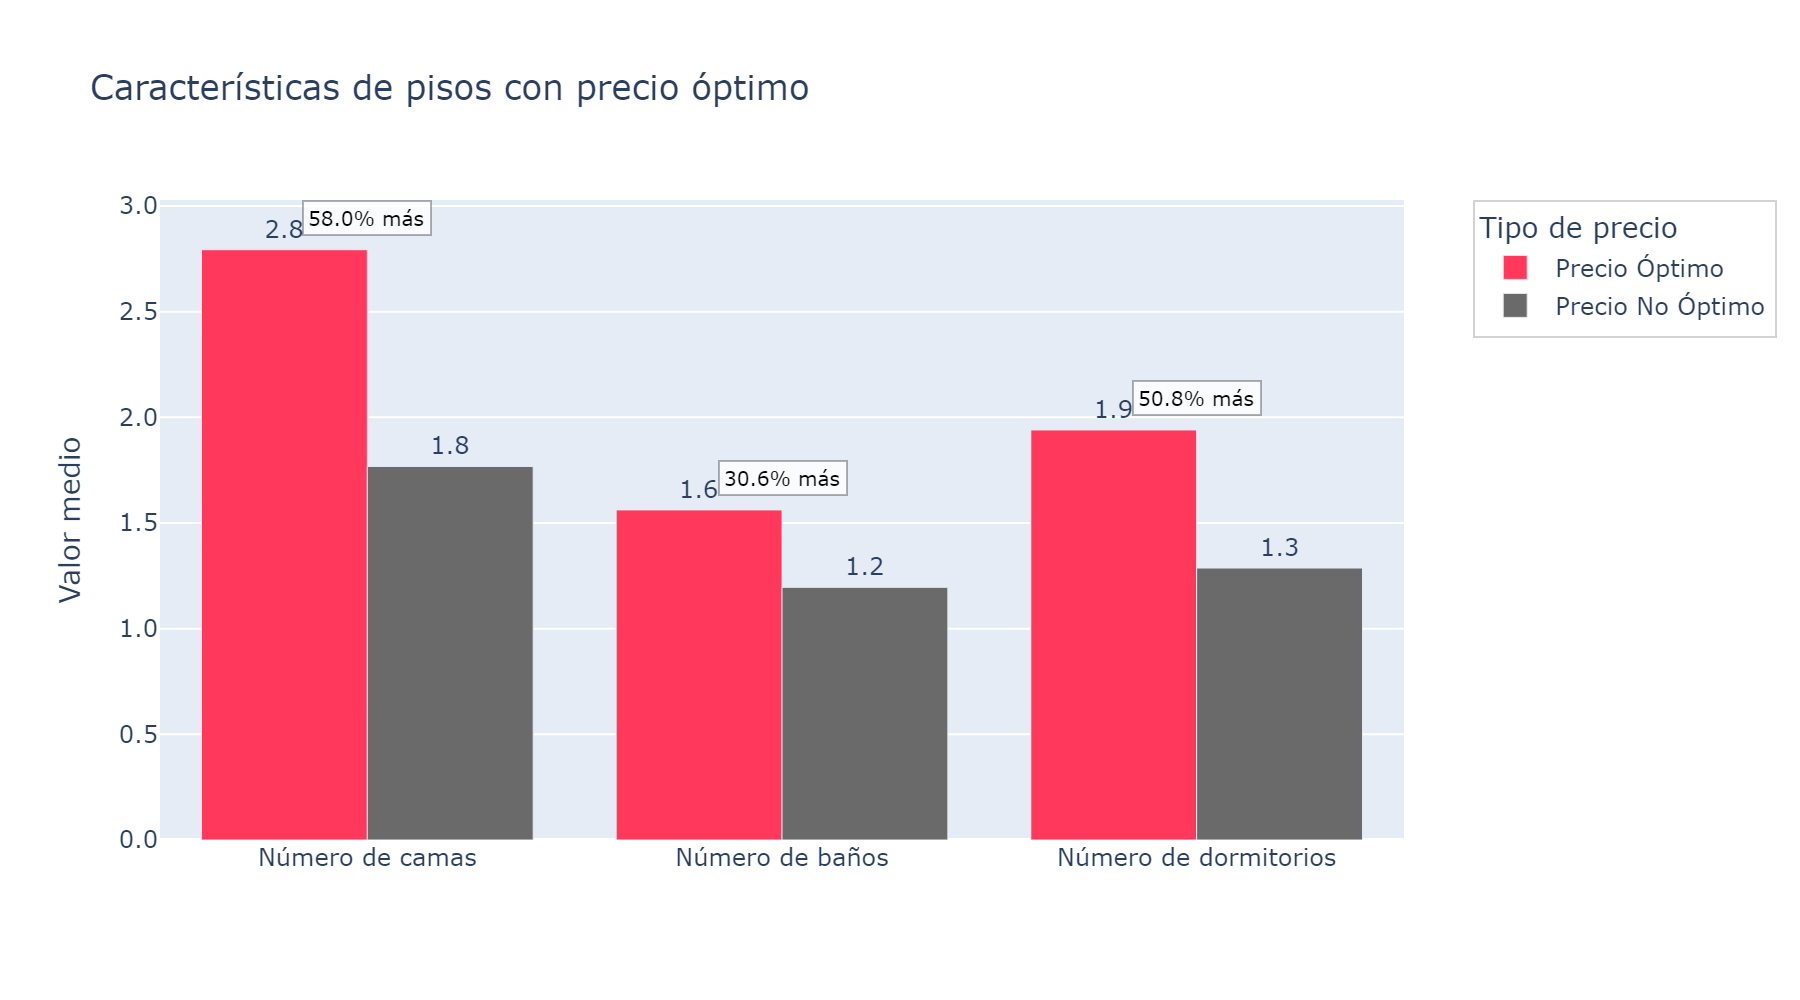

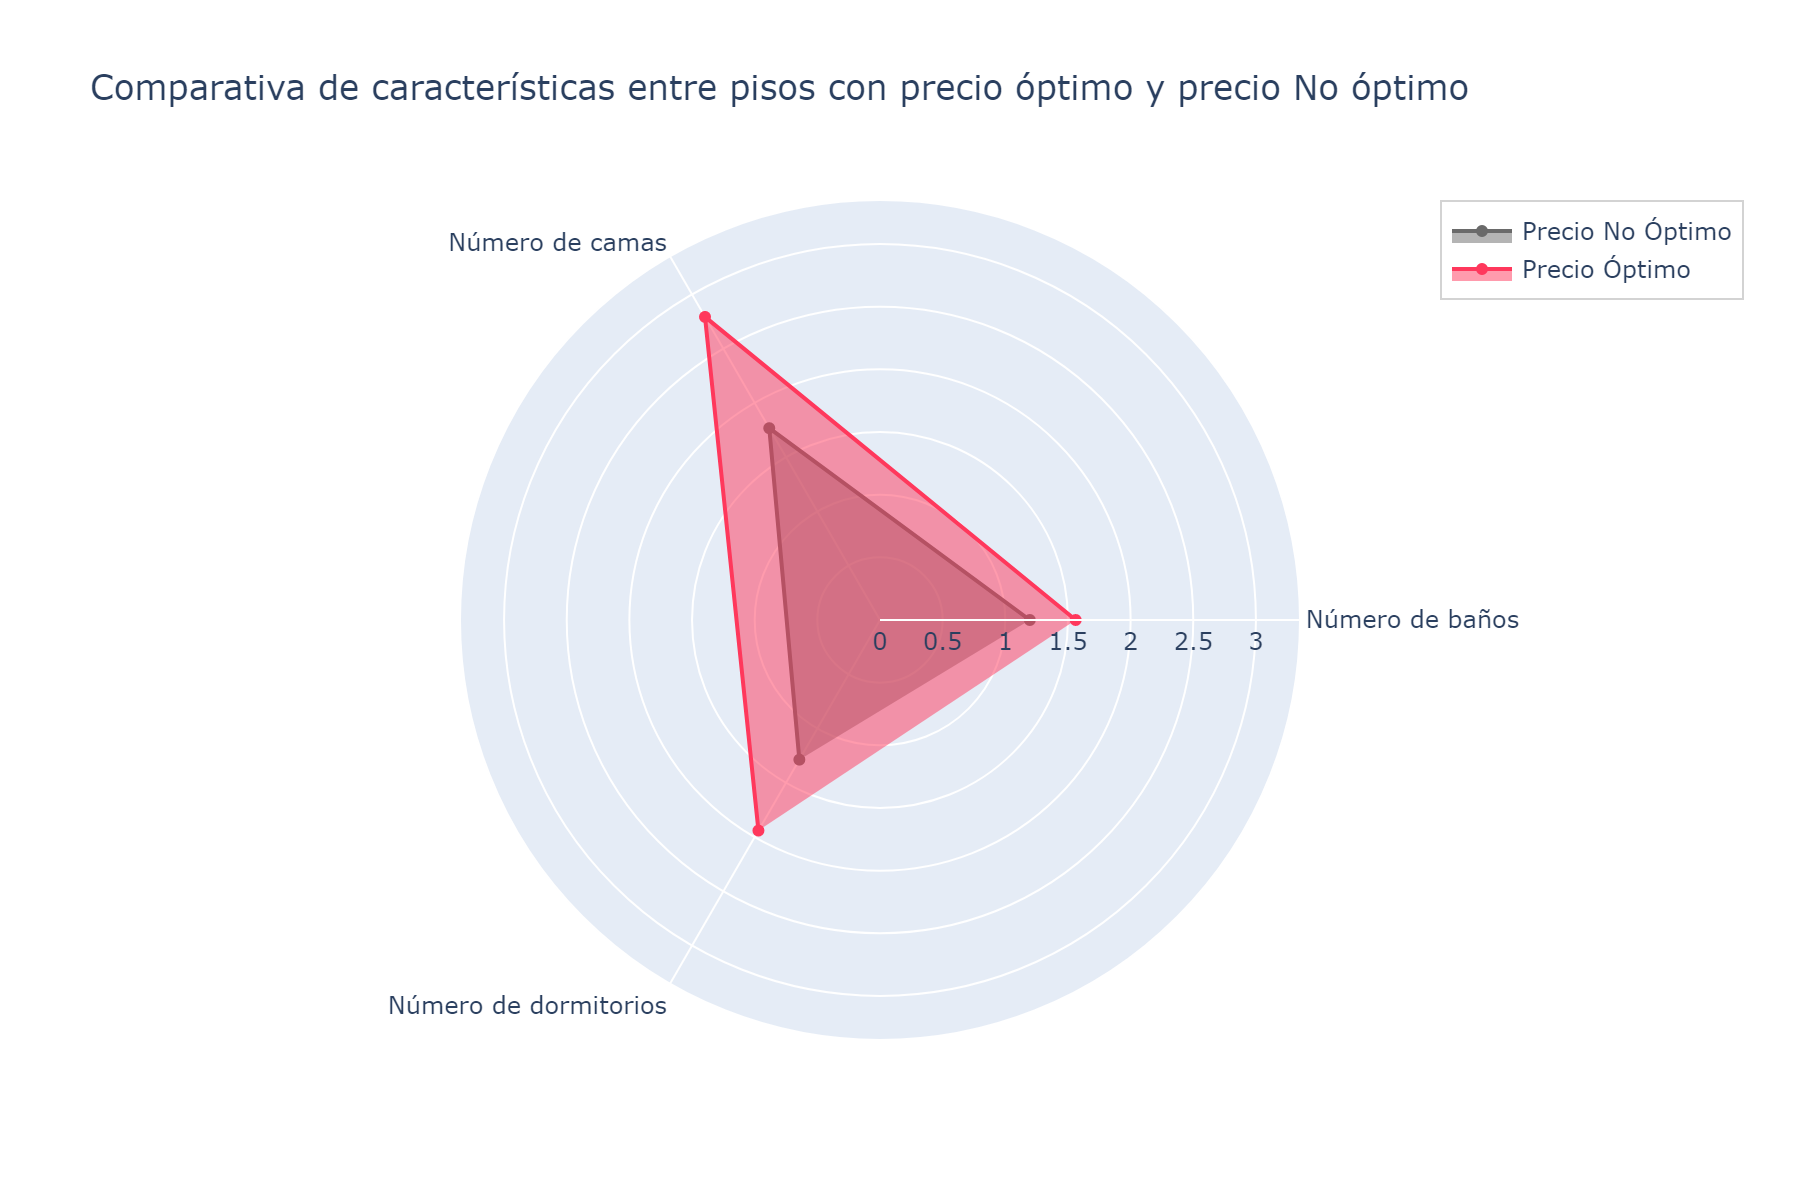

In [25]:
variables = ["beds", "bathrooms", "bedrooms"]
stats_df = pd.DataFrame()

for var in variables:
    media_optimo = df[df["precio_optimo"] == True][var].mean()
    media_no_optimo = df[df["precio_optimo"] == False][var].mean()
    
    stats_df = pd.concat([stats_df, pd.DataFrame({
        'variable': [var, var],
        'grupo': ['Precio Óptimo', 'Precio No Óptimo'],
        'valor_medio': [media_optimo, media_no_optimo]
    })])

nombre_variables = {
    "beds": "Número de camas",
    "bathrooms": "Número de baños",
    "bedrooms": "Número de dormitorios"
}

stats_df['variable_nombre'] = stats_df['variable'].map(nombre_variables)

fig = px.bar(
    stats_df, 
    x='variable_nombre', 
    y='valor_medio', 
    color='grupo',
    barmode='group',
    title='Características de pisos con precio óptimo',
    labels={'valor_medio': 'Valor medio', 'variable_nombre': 'Característica', 'grupo': 'Tipo de precio'},
    color_discrete_map={'Precio Óptimo': '#ff385c', 'Precio No Óptimo': '#6a6a6a'}
)

fig.update_traces(texttemplate='%{y:.1f}', textposition='outside')

fig.update_layout(
    legend=dict(
        orientation='v',       
        yanchor='top',           
        y=1,                      
        xanchor='right',         
        x=1.3,                   
        bgcolor='rgba(255,255,255,0.9)',  
        bordercolor='lightgray',  
        borderwidth=1            
    ),
    yaxis=dict(title='Valor medio', tickformat='.1f'),
    xaxis=dict(title=None),
    height=500,
    width=900
)

for var in nombre_variables.values():
    subset = stats_df[stats_df['variable_nombre'] == var]
    valor_optimo = subset[subset['grupo'] == 'Precio Óptimo']['valor_medio'].values[0]
    valor_no_optimo = subset[subset['grupo'] == 'Precio No Óptimo']['valor_medio'].values[0]
    
    if valor_no_optimo > 0:
        pct_diff = ((valor_optimo - valor_no_optimo) / valor_no_optimo) * 100
        direccion = "más" if pct_diff > 0 else "menos"
        
        fig.add_annotation(
            x=var,
            y=max(valor_optimo, valor_no_optimo) + 0.15,
            text=f"{abs(pct_diff):.1f}% {direccion}",
            showarrow=False,
            font=dict(size=10, color="black"),
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="rgba(0, 0, 0, 0.3)",
            borderwidth=1,
            borderpad=2
        )

fig.show()

radar_df = stats_df.pivot(index='grupo', columns='variable_nombre', values='valor_medio').reset_index()

fig_radar = go.Figure()

for i, grupo in enumerate(radar_df['grupo']):
    fig_radar.add_trace(go.Scatterpolar(
        r=radar_df.iloc[i, 1:].values.tolist(),
        theta=radar_df.columns[1:].tolist(),
        fill='toself',
        name=grupo,
        line_color='#ff385c' if grupo == 'Precio Óptimo' else '#6a6a6a'
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, stats_df['valor_medio'].max() * 1.2]
        )
    ),
    title='Comparativa de características entre pisos con precio óptimo y precio No óptimo',
    showlegend=True,
    legend=dict(
        orientation='v',          
        yanchor='top',            
        y=1,                      
        xanchor='right',          
        x=1.1,                    
        bgcolor='rgba(255,255,255,0.9)',  
        bordercolor='lightgray', 
        borderwidth=1            
    ),
    margin=dict(r=100),          
    height=600,
    width=900
)

fig_radar.show()

fig.write_image("docs/comparativa_camas_baños_dormitorios_precio.png", scale=2)
fig_radar.write_image("docs/comparativa_camas_baños_dormitorios_precio_radar.png", scale=2)
display(Image(filename="docs/comparativa_camas_baños_dormitorios_precio.png"))
display(Image(filename="docs/comparativa_camas_baños_dormitorios_precio_radar.png"))

## <span style="color: #ff385c;"> ¿Qué comodidades tienen los pisos con precio óptimo?</span>

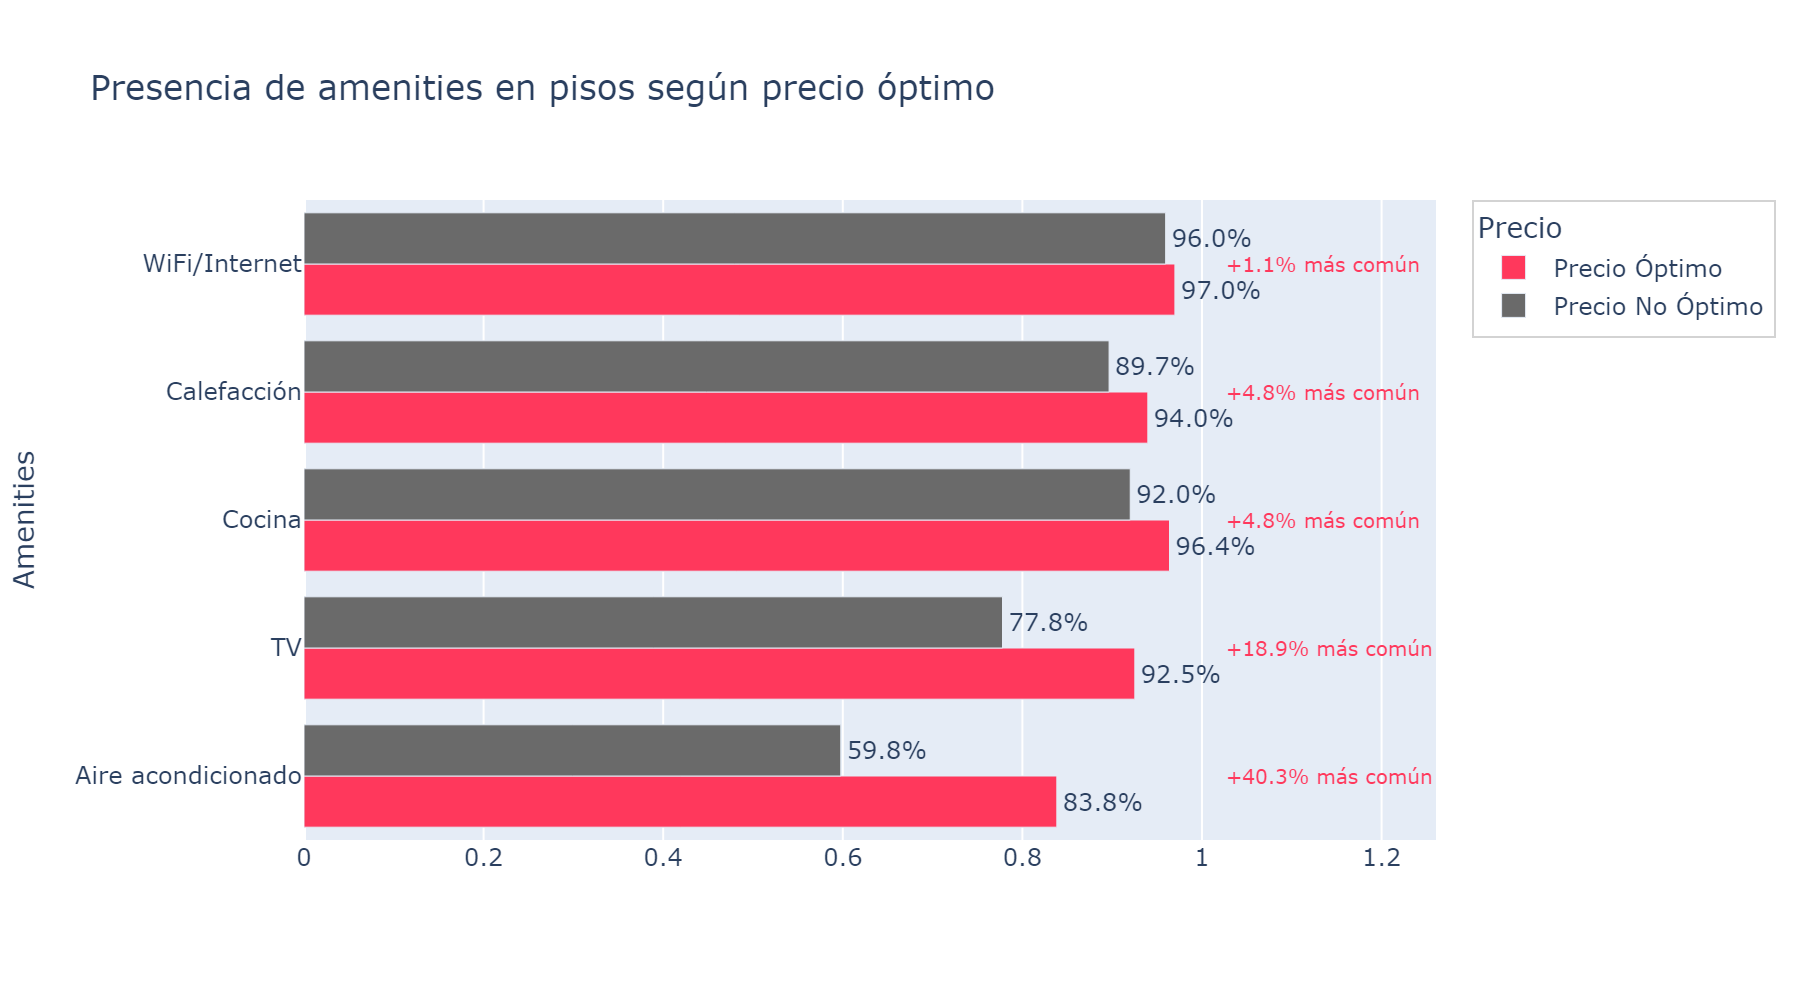

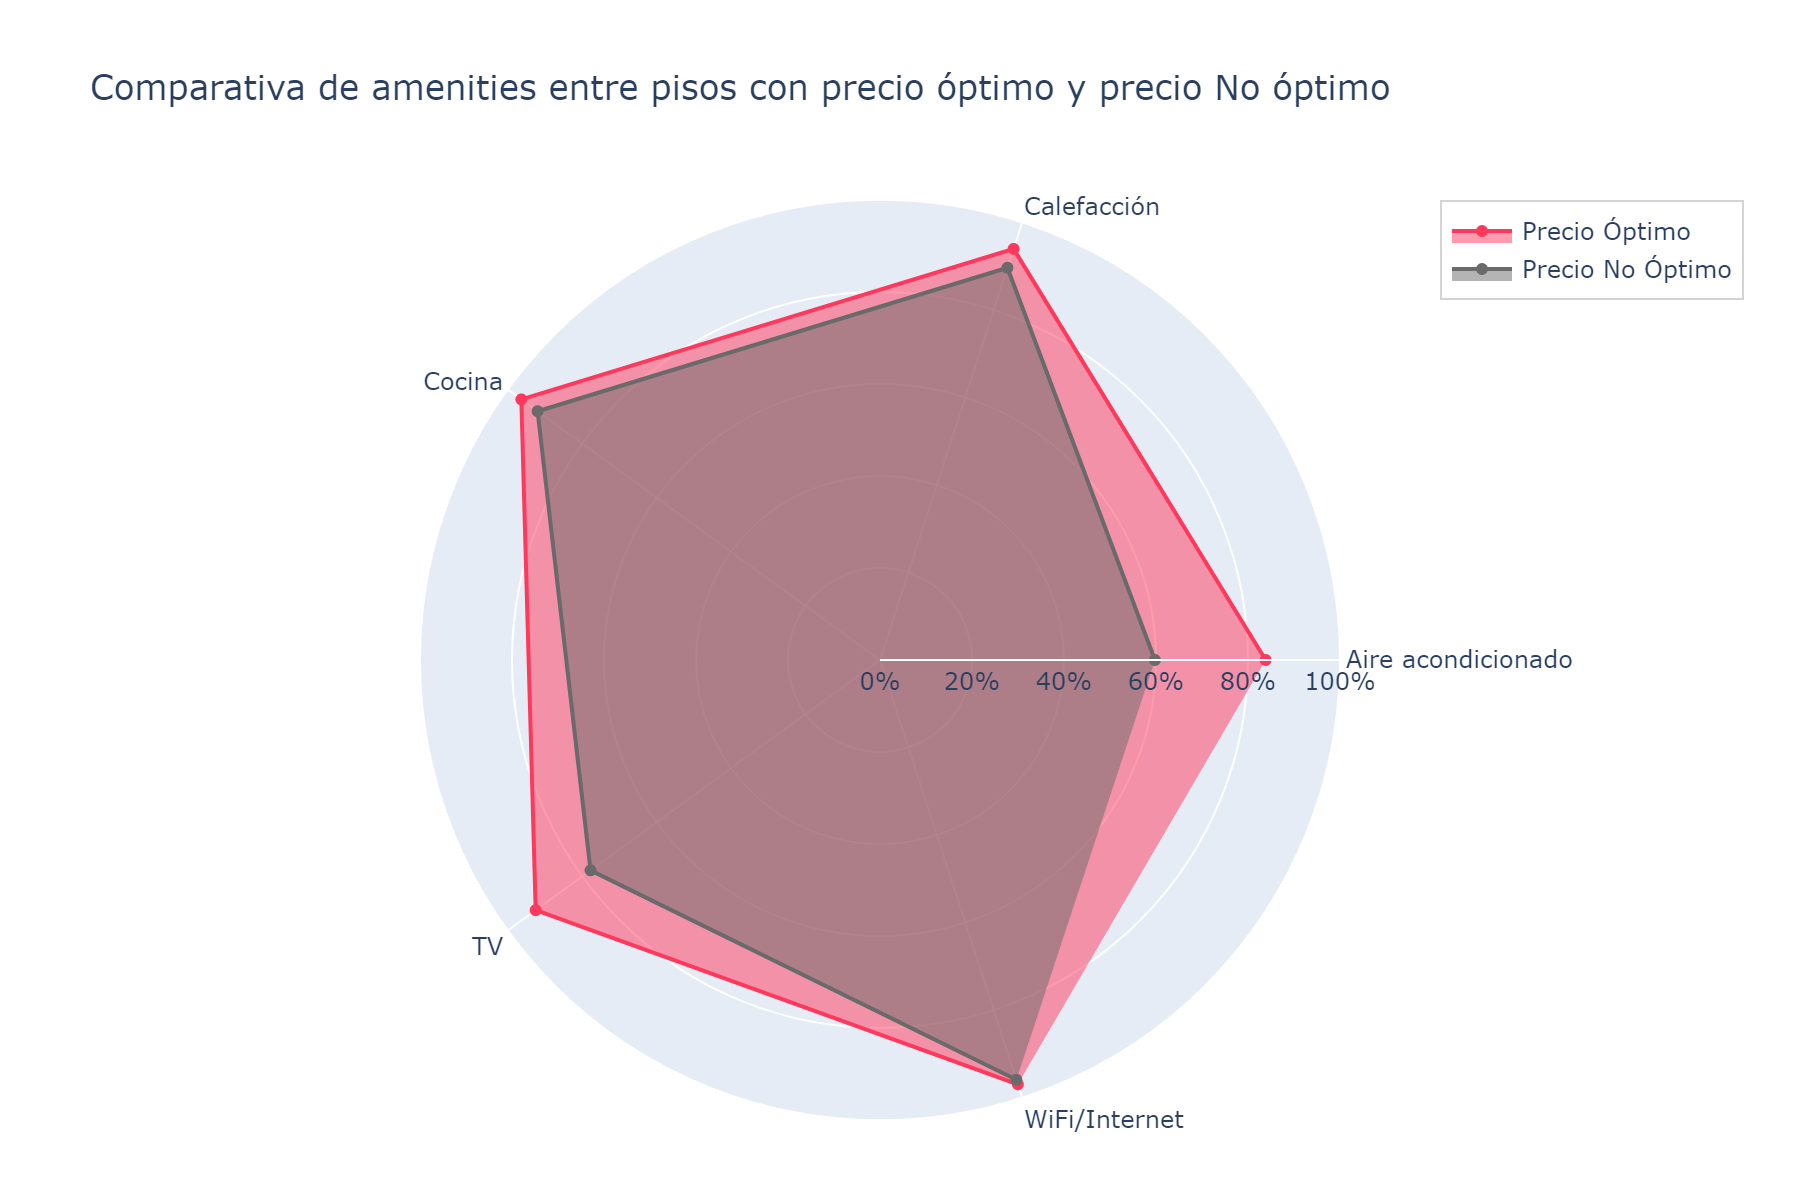

In [26]:
# Calcular el porcentaje de pisos según los amenities
amenities = ["amenities_wifi_internet", "amenities_tv", "amenities_air_conditioning", "amenities_heating", "amenities_kitchen"]
df_comodidades = df[["precio_optimo"] + amenities].groupby("precio_optimo", as_index=False).mean()

# Transformar los datos para la visualización
df_comodidades = (
    df_comodidades
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "amenities", "value": "porcentaje"})
)

# Nombres de los amenities 
nombre_amenities = {
    "amenities_wifi_internet": "WiFi/Internet",
    "amenities_tv": "TV",
    "amenities_air_conditioning": "Aire acondicionado",
    "amenities_heating": "Calefacción",
    "amenities_kitchen": "Cocina"
}

df_comodidades["amenities_nombre"] = df_comodidades["amenities"].map(nombre_amenities)

# Calcular la diferencia porcentual entre precio óptimo y no óptimo
pivot_df = df_comodidades.pivot(index='amenities', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_comodidades_ = pd.merge(
    df_comodidades,
    pivot_df[['amenities', 'diferencia', 'diferencia_porcentual']],
    on='amenities'
)

# Ordenar por la diferencia para mostrar primero los más asociados con precio óptimo
top_amenities = pivot_df.sort_values('diferencia', ascending=False)['amenities'].tolist()
df_comodidades_['amenities_orden'] = pd.Categorical(df_comodidades_['amenities'], categories=top_amenities, ordered=True)

# Crear un gráfico de barras ordenado con etiquetas mejoradas 
fig = px.bar(
    df_comodidades_.sort_values('amenities_orden'), 
    y='amenities_nombre', 
    x='porcentaje', 
    color='precio_optimo',
    barmode='group',
    title='Presencia de amenities en pisos según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'amenities_nombre': 'Amenities',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_map={True: '#ff385c', False: '#6a6a6a'}
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        orientation='v',       
        yanchor='top',           
        y=1,                      
        xanchor='right',         
        x=1.3,                   
        bgcolor='rgba(255,255,255,0.9)',  
        bordercolor='lightgray',  
        borderwidth=1            
    ),
    yaxis=dict(title='Amenities', tickformat='.1f'),
    xaxis=dict(title=None),
    height=500,
    width=900
)

# Actualizar nombres en la leyenda
fig.data[0].name = 'Precio Óptimo'
fig.data[1].name = 'Precio No Óptimo'
fig.update_traces(textposition='outside')

# Añadir anotaciones para mostrar la diferencia porcentual
for i, amenity in enumerate(top_amenities):
    subset = df_comodidades_[df_comodidades_['amenities'] == amenity]
    diff_pct = subset['diferencia_porcentual'].values[0]
    
    # Solo añadir anotación si hay una diferencia significativa
    if abs(diff_pct) > 1:
        y_pos = nombre_amenities[amenity]
        
        # Determinar si es más común en precio óptimo o no óptimo
        if diff_pct > 0:
            texto = f"+{diff_pct:.1f}% más común"
            color = '#ff385c'
        else:
            texto = f"{diff_pct:.1f}% menos común"
            color = '#6a6a6a'
        
        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Crear un gráfico de radar para comparar la presencia de amenities
radar_df = df_comodidades.pivot(index='precio_optimo', columns='amenities_nombre', values='porcentaje').reset_index()

fig_radar = go.Figure()

# Añadir una traza para cada grupo
for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = '#ff385c'if precio else '#6a6a6a'
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title='Comparativa de amenities entre pisos con precio óptimo y precio No óptimo',
    showlegend=True,
    legend=dict(
        orientation='v',          
        yanchor='top',            
        y=1,                      
        xanchor='right',         
        x=1.1,                   
        bgcolor='rgba(255,255,255,0.9)',  
        bordercolor='lightgray',  
        borderwidth=1            
    ),
    margin=dict(r=100, t=100, b=40),  
    height=600,
    width=900
)




fig_radar.show()

fig.write_image("docs/comparativa_amenities.png", scale=2)
fig_radar.write_image("docs/comparativa_amenities_radar.png", scale=2)
display(Image(filename="docs/comparativa_amenities.png"))
display(Image(filename="docs/comparativa_amenities_radar.png"))


### Tipo de habitaciones en pisos con precio óptimo

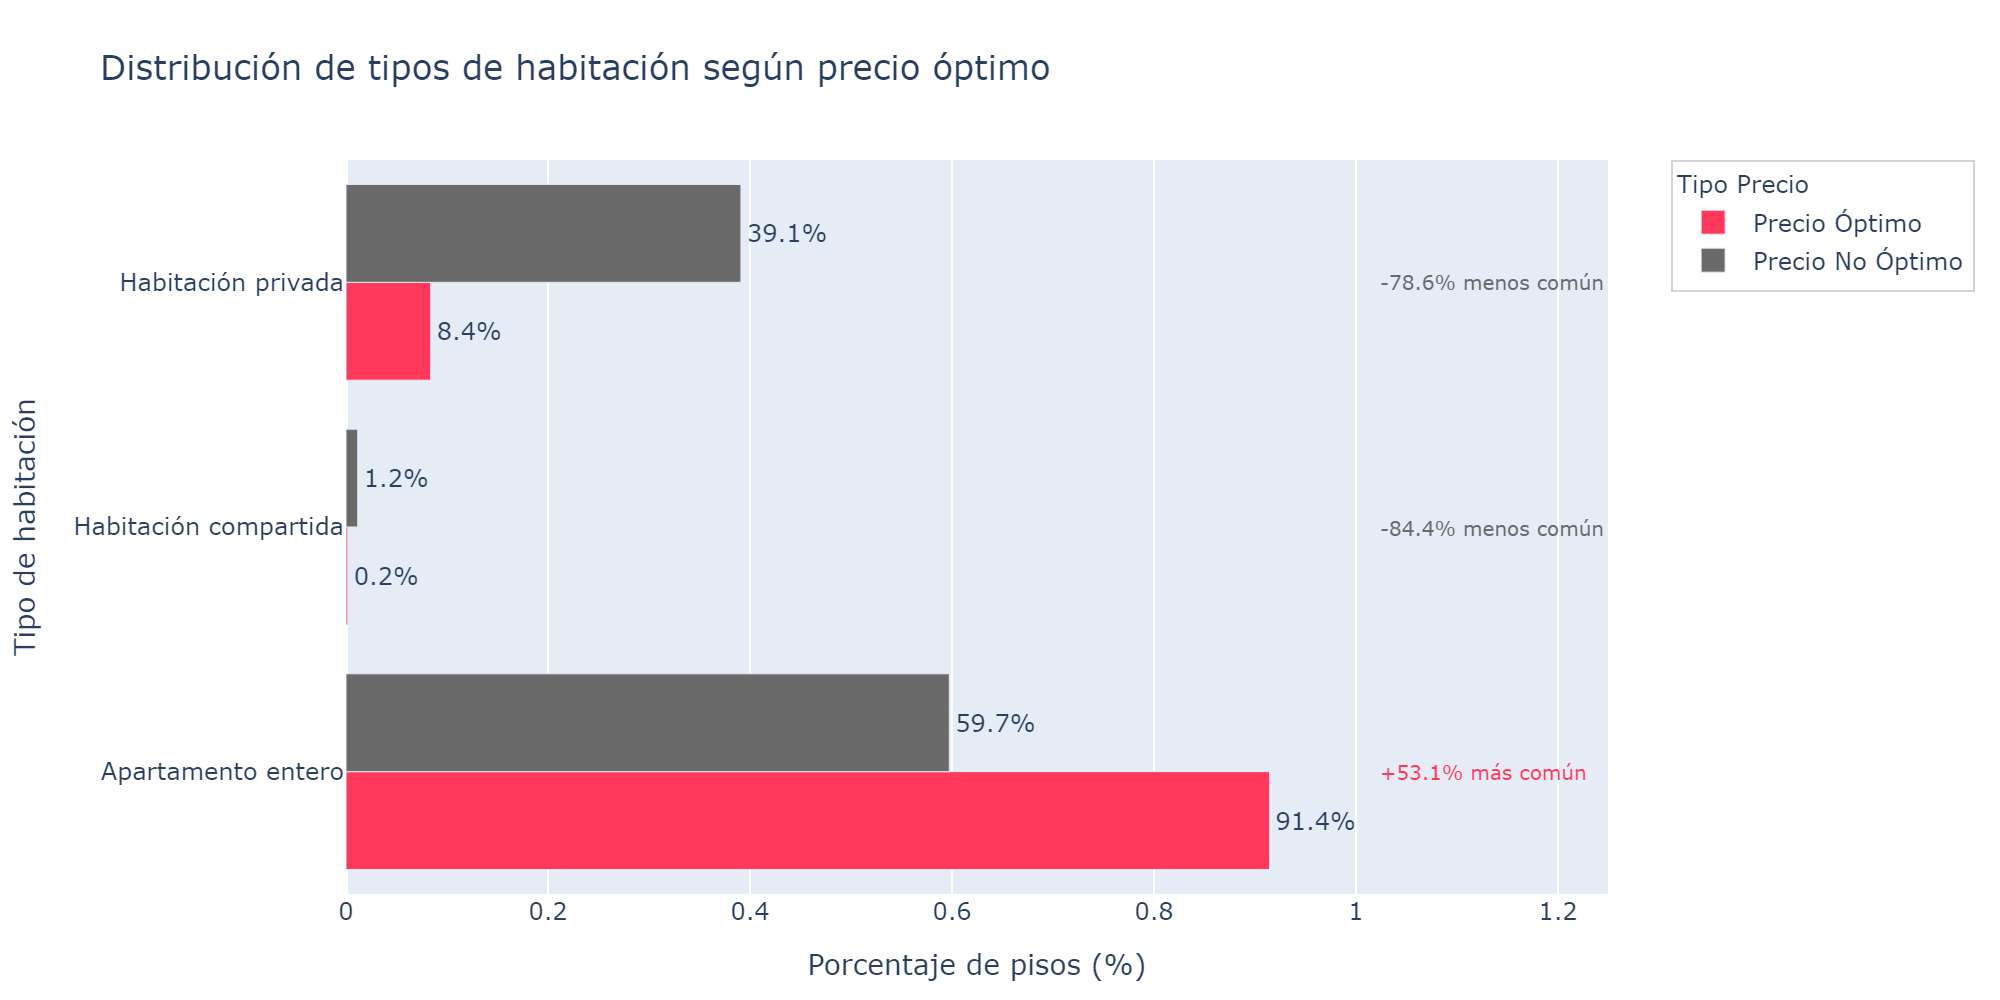

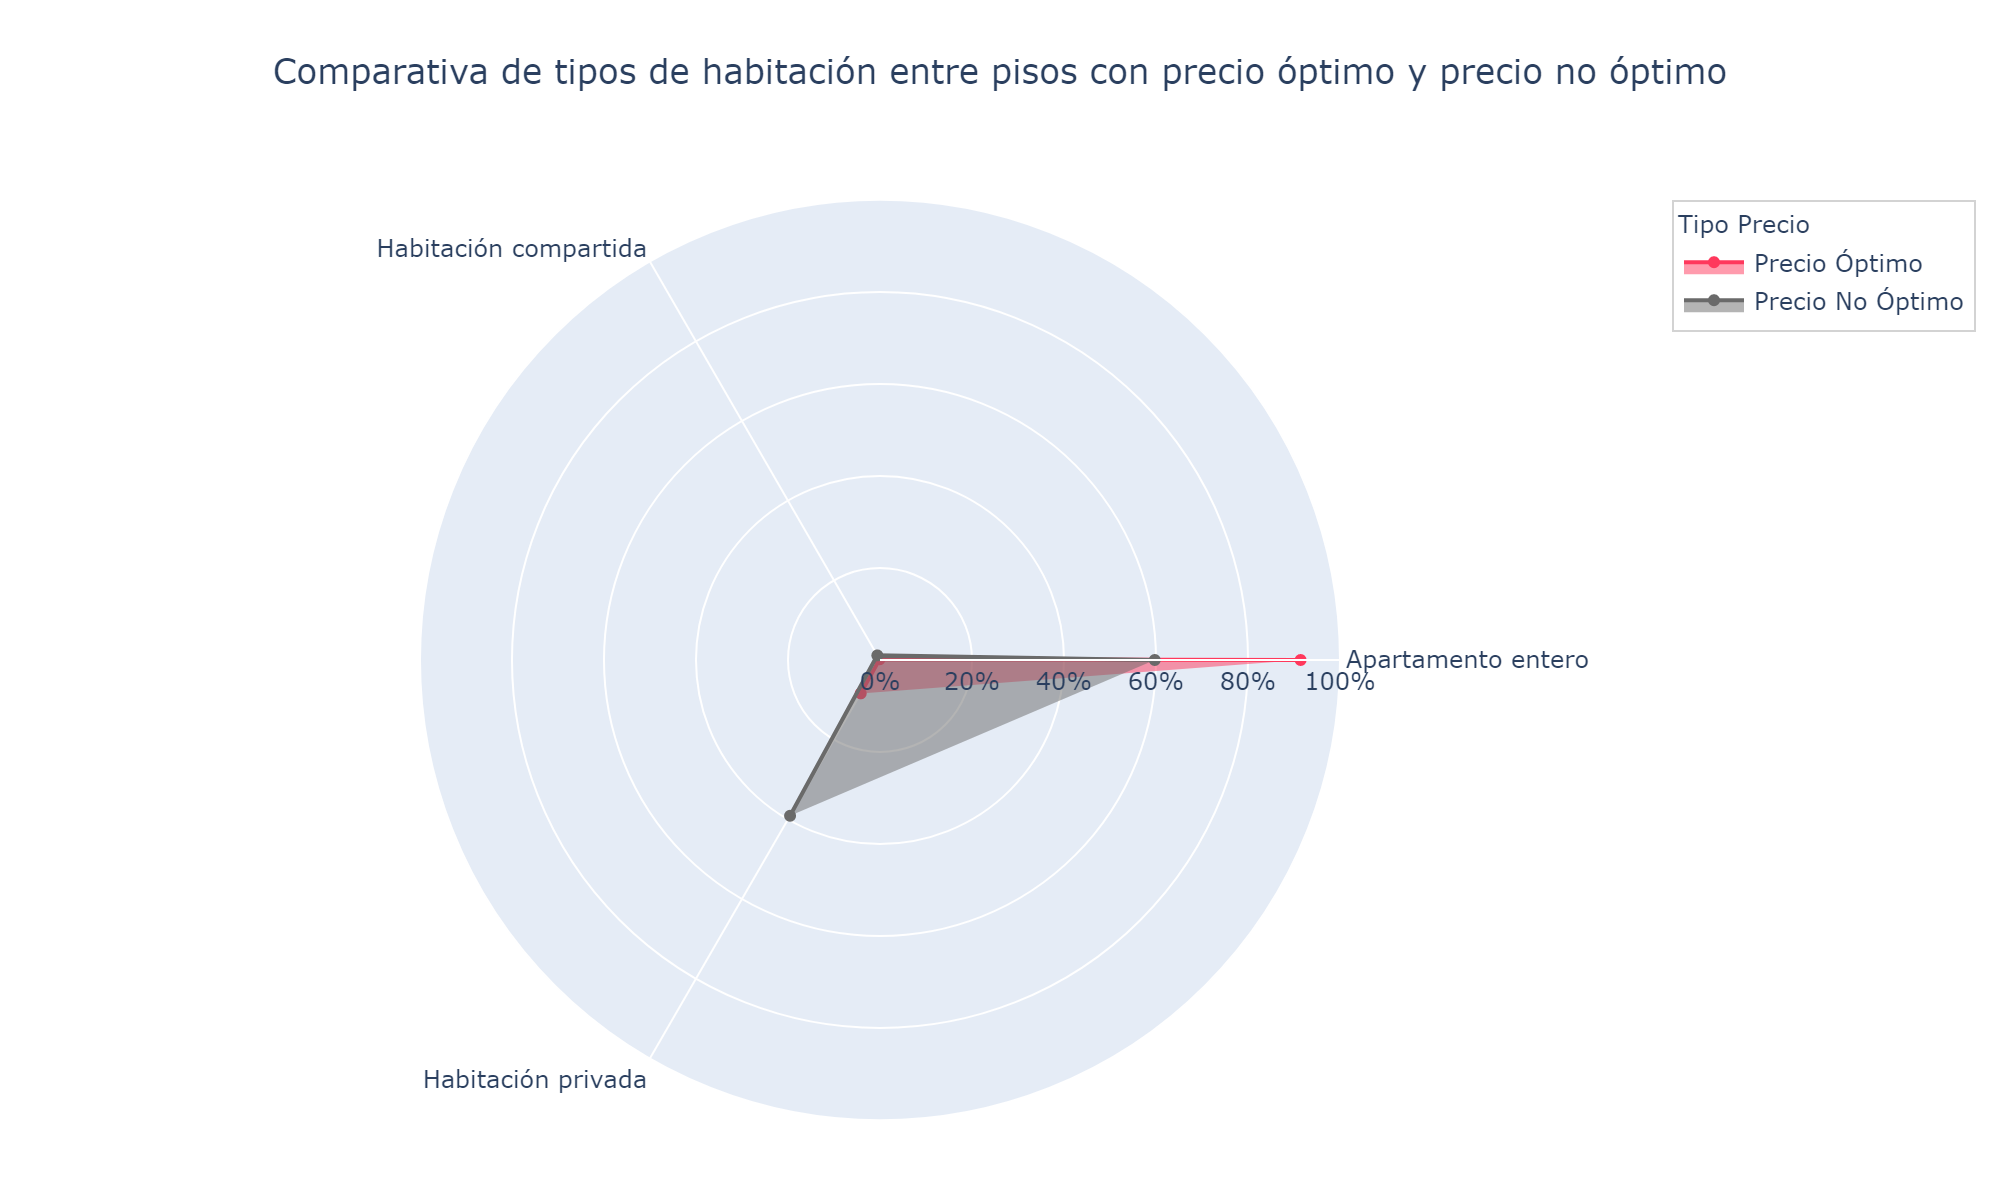

In [27]:
# Crear variables dummies para tipo_habitacion 
df_tipo_habitacion_dummies = pd.get_dummies(df['room_type'], prefix='tipo_habitacion')

# Calcular el porcentaje de pisos según el tipo de habitación
df_tipo_habitacion_stats = df[['precio_optimo']].join(df_tipo_habitacion_dummies).groupby('precio_optimo', as_index=False).mean()

# Transformar los datos para la visualización
df_tipo_habitacion_stats = (
    df_tipo_habitacion_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "tipo_habitacion", "value": "porcentaje"})
)

# Mejorar los nombres de las categorías
nombre_tipo_habitacion = {
    "tipo_habitacion_entire_home_apt": "Apartamento entero",
    "tipo_habitacion_private_room": "Habitación privada",
    "tipo_habitacion_shared_room": "Habitación compartida"
}

df_tipo_habitacion_stats["tipo_habitacion_nombre"] = df_tipo_habitacion_stats["tipo_habitacion"].map(nombre_tipo_habitacion)

# Calcular diferencia porcentual
pivot_df = df_tipo_habitacion_stats.pivot(index='tipo_habitacion', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_tipo_habitacion_stats,
    pivot_df[['tipo_habitacion', 'diferencia', 'diferencia_porcentual']],
    on='tipo_habitacion'
)

# Ordenar por la diferencia
top_tipo_habitacion = pivot_df.sort_values('diferencia', ascending=False)['tipo_habitacion'].tolist()
df_final['tipo_habitacion_orden'] = pd.Categorical(df_final['tipo_habitacion'], categories=top_tipo_habitacion, ordered=True)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values('tipo_habitacion_orden'),
    y='tipo_habitacion_nombre',
    x='porcentaje',
    color='precio_optimo',
    barmode='group',
    title='Distribución de tipos de habitación según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'tipo_habitacion_nombre': 'Tipo de habitación',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_map={True: '#ff385c', False: '#6a6a6a'}
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title='Tipo Precio',
        title_font=dict(size=12),
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.05,  
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='lightgray',
        borderwidth=1
    ),
    margin=dict(r=100, t=80, b=40),  
    height=500,
    width=1000  
)

fig.for_each_trace(lambda t: t.update(name='Precio Óptimo' if t.name == 'True' else 'Precio No Óptimo'))


fig.update_traces(textposition='outside')

# Anotaciones con diferencias porcentuales
for i, tipo in enumerate(top_tipo_habitacion):
    subset = df_final[df_final['tipo_habitacion'] == tipo]
    diff_pct = subset['diferencia_porcentual'].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_tipo_habitacion[tipo]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = '#ff385c' if diff_pct > 0 else '#6a6a6a'

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Gráfico de radar
radar_df = df_tipo_habitacion_stats.pivot(index='precio_optimo', columns='tipo_habitacion_nombre', values='porcentaje').reset_index()

fig_radar = go.Figure()

for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = '#ff385c' if precio else '#6a6a6a'
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title={
        'text': 'Comparativa de tipos de habitación entre pisos con precio óptimo y precio no óptimo',
        'y': 0.95,
        'x': 0.5
    },
    showlegend=True,
    legend=dict(
        title='Tipo Precio',
        title_font=dict(size=12),
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.05,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='lightgray',
        borderwidth=1
    ),
    margin=dict(t=100, b=40, r=150),
    height=600,
    width=1000
)

fig_radar.show()


fig.write_image("docs/comparativa_rooms_precio.png", scale=2)
fig_radar.write_image("docs/comparativa_rooms_precio_radar.png", scale=2)
display(Image(filename="docs/comparativa_rooms_precio.png"))
display(Image(filename="docs/comparativa_rooms_precio_radar.png"))

### Tipo de cama en los pisos con precio óptimo

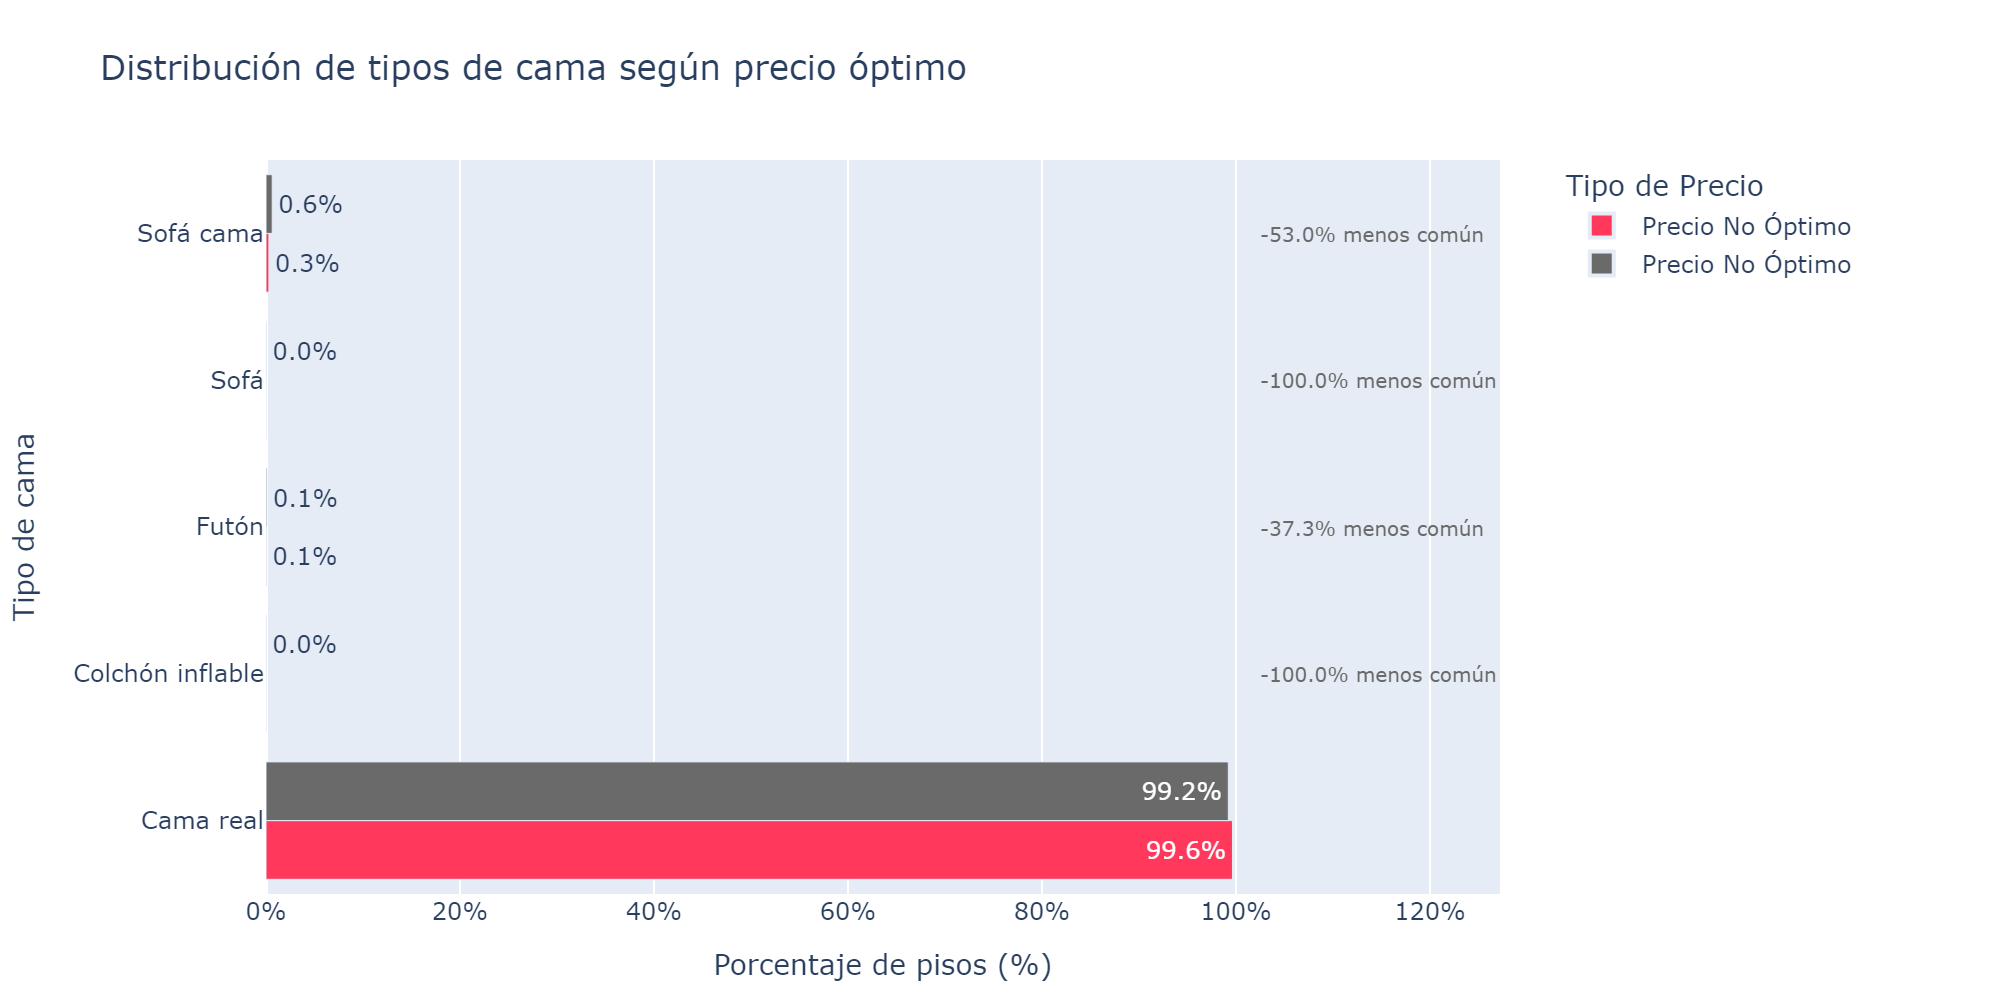

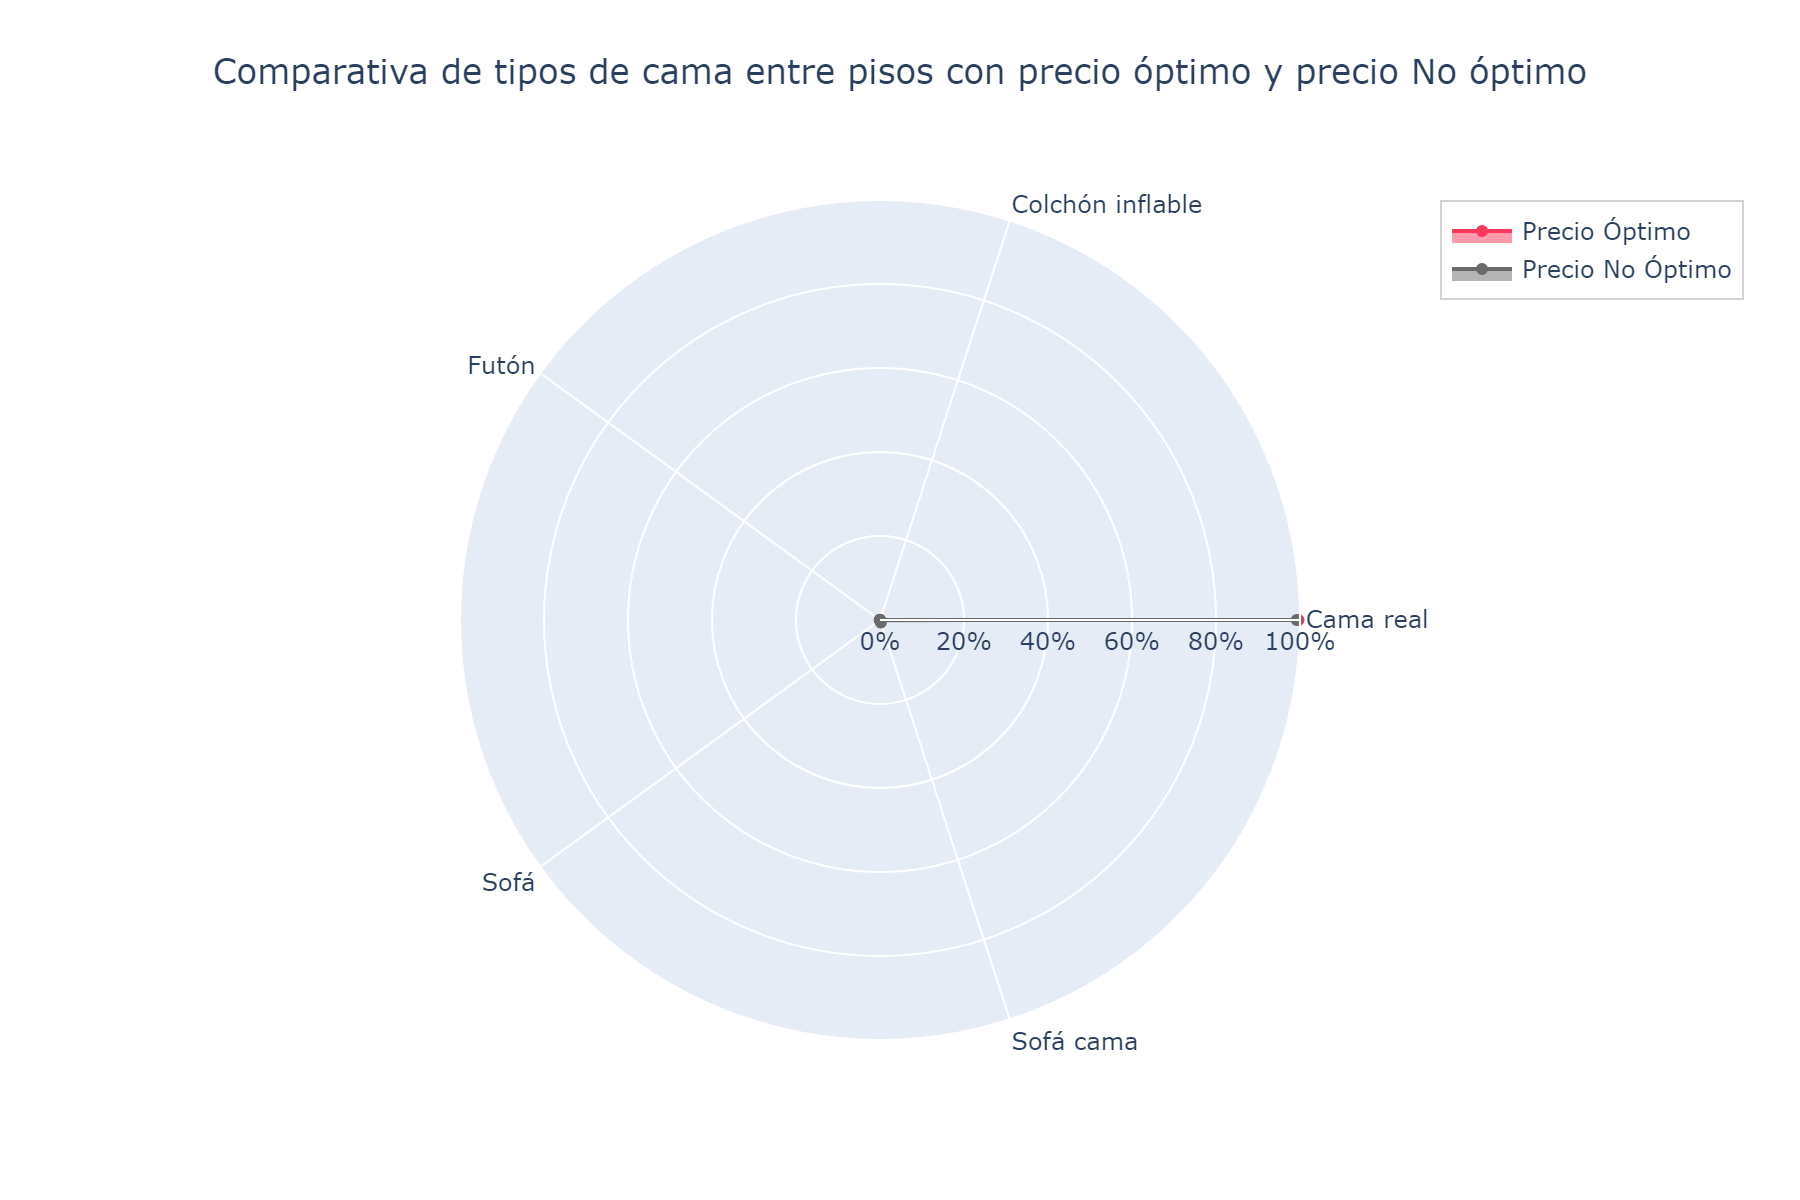

In [28]:
# Crear variables dummies para bed_type
df_bed_dummies = pd.get_dummies(df['bed_type'], prefix='bed_type')

# Calcular el porcentaje de pisos según el tipo de cama
df_bed_stats = df[['precio_optimo']].join(df_bed_dummies).groupby('precio_optimo', as_index=False).mean()

# Transformar los datos para la visualización
df_bed_stats = (
    df_bed_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "bed_type", "value": "porcentaje"})
)

nombre_bed_type = {
    "bed_type_airbed": "Colchón inflable",
    "bed_type_couch": "Sofá",
    "bed_type_futon": "Futón",
    "bed_type_pull_out_sofa": "Sofá cama",
    "bed_type_real_bed": "Cama real"
}

df_bed_stats["bed_type_nombre"] = df_bed_stats["bed_type"].map(nombre_bed_type)

# Calcular diferencia porcentual
pivot_df = df_bed_stats.pivot(index='bed_type', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_bed_stats,
    pivot_df[['bed_type', 'diferencia', 'diferencia_porcentual']],
    on='bed_type'
)

# Ordenar por la diferencia
top_bed_types = pivot_df.sort_values('diferencia', ascending=False)['bed_type'].tolist()
df_final['bed_type_orden'] = pd.Categorical(df_final['bed_type'], categories=top_bed_types, ordered=True)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values('bed_type_orden'),
    y='bed_type_nombre',
    x='porcentaje',
    color='precio_optimo',
    barmode='group',
    title='Distribución de tipos de cama según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'bed_type_nombre': 'Tipo de cama',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_sequence=custom_palette
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text='Tipo de Precio',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.05,
        traceorder='normal',
        itemsizing='constant'
    ),
    xaxis=dict(tickformat='.0%'),
    margin=dict(t=80, b=40, r=250),
    height=500,
    width=1000
)

fig.for_each_trace(lambda t: t.update(name='Precio Óptimo' if t.name == 'True' else 'Precio No Óptimo'))

# Cambiar los valores de la leyenda (True/False) por 'Precio Óptimo' y 'Precio No Óptimo'
fig.for_each_trace(lambda t: t.update(name='Precio Óptimo' if t.name == 'True' else 'Precio No Óptimo'))

# Cambiar los valores de la leyenda (True/False) por 'Precio Óptimo' y 'Precio No Óptimo'
fig.for_each_trace(lambda t: t.update(name='Precio Óptimo' if t.name == 'True' else 'Precio No Óptimo'))

# Anotaciones con diferencias porcentuales
for i, bed in enumerate(top_bed_types):
    subset = df_final[df_final['bed_type'] == bed]
    diff_pct = subset['diferencia_porcentual'].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_bed_type[bed]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = '#ff385c'if diff_pct > 0 else '#6a6a6a'

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Gráfico de radar
radar_df = df_bed_stats.pivot(index='precio_optimo', columns='bed_type_nombre', values='porcentaje').reset_index()

fig_radar = go.Figure()

for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = '#ff385c' if precio else '#6a6a6a'
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title={
        'text': 'Comparativa de tipos de cama entre pisos con precio óptimo y precio No óptimo',
        'y': 0.95,
        'x': 0.5
    },
    showlegend=True,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='right',
        x=1.1,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='lightgray',
        borderwidth=1
    ),
    margin=dict(r=100),
    height=600,
    width=900
)


fig_radar.show()

fig.write_image("docs/comparativa_camas_precio.png", scale=2)
fig_radar.write_image("docs/comparativa_camas_precio_radar.png", scale=2)
display(Image(filename="docs/comparativa_camas_precio.png"))
display(Image(filename="docs/comparativa_camas_precio_radar.png"))


# <span style="color: #ff385c;"> 5. Análisis contractua</span>l

## <span style="color: #ff385c;"> ¿Cómo afecta el número de noches mínimas al precio óptimo?</span>

In [29]:

variable_analisis = 'minimum_nights'
Q1 = np.percentile(df[variable_analisis], 25)
Q3 = np.percentile(df[variable_analisis], 75)

IQR = Q3 - Q1

print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print('\n')
print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
print('\n')

# Se eliminan los outliers del límite superior
df = df[df[variable_analisis] <= limite_superior]

# Marcar que ya se ejecutó
outliers_eliminados = True  

print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
print(f"Nuevo tamaño del DataFrame: {df.shape}")



Valor del primer cuartil (25%): 1.00
Valor del tercer cuartil (75%): 3.00
Valor del rango intercuartil (IQR): 2.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -2.00
	 - Límite superior (considerado extremadamente alto): 6.00


Se eliminaron los valores mayores a 6.00 en 'minimum_nights'.
Nuevo tamaño del DataFrame: (13032, 55)


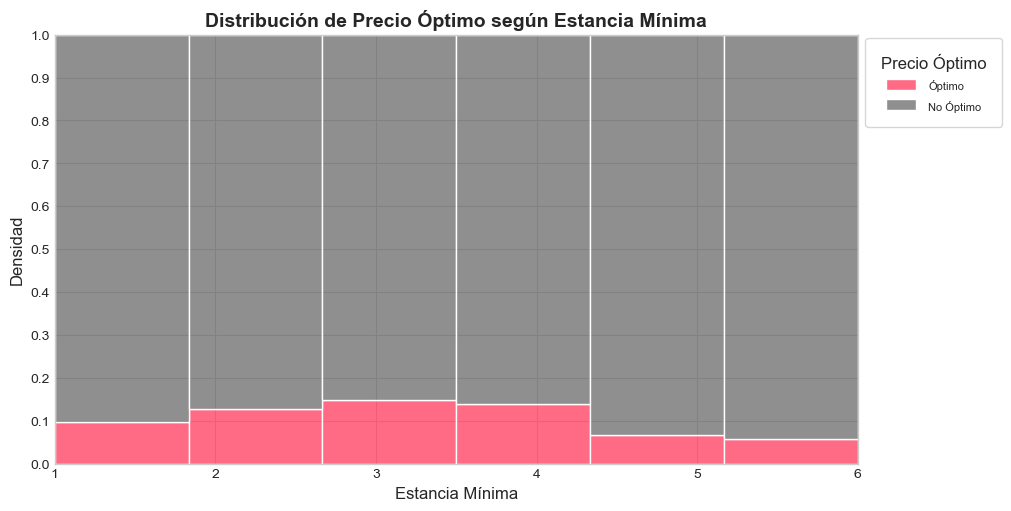

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de minimum nights:
- 2.0: 39.29% del total
- 1.0: 31.10% del total
- 3.0: 22.99% del total


Minimum Nights % Distribución Óptimos
0               1                  31.1%
1               2                 39.29%
2               3                 22.99%
3               4                  4.48%
4               5                  1.82%
5               6                  0.32%

In [30]:
# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Gráfico de histogramas con bins
palette_airbnb = {True: "#ff385c", False: "#6a6a6a"}
sns.histplot(
    data=df,
    x="minimum_nights",
    hue="precio_optimo",
    multiple="fill",
    bins=int(df["minimum_nights"].max()),  
    palette=palette_airbnb,
    ax=ax
)

# Títulos y etiquetas
ax.set_title("Distribución de Precio Óptimo según Estancia Mínima", fontsize=14, fontweight="bold")
ax.set_xlabel("Estancia Mínima", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use valores enteros
ax.set_xticks(np.arange(df["minimum_nights"].min(), df["minimum_nights"].max() + 1, 1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Ajustar el eje X a los valores reales
ax.set_xlim(df["minimum_nights"].min(), df["minimum_nights"].max())

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Calcular el porcentaje de pisos con precio óptimo por mínimo de noches
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("minimum_nights")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Minimum Nights", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar los valores con mayor concentración de precios óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de minimum nights:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Minimum Nights']}: {row['% Distribución Óptimos']:.2f}% del total")

# Convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios


## <span style="color: #ff385c;"> ¿Cómo afecta el número de noches máximas al precio óptimo?</span>

In [31]:
variable_analisis = 'maximum_nights'
Q1 = np.percentile(df[variable_analisis], 25)
Q3 = np.percentile(df[variable_analisis], 75)

IQR = Q3 - Q1

print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print('\n')
print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
print('\n')

# Se eliminan los outliers del límite superior
df = df[df[variable_analisis] <= limite_superior]

# Marcar que ya se ejecutó
outliers_eliminados = True  
print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
print(f"Nuevo tamaño del DataFrame: {df.shape}")

Valor del primer cuartil (25%): 32.00
Valor del tercer cuartil (75%): 1125.00
Valor del rango intercuartil (IQR): 1093.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -1607.50
	 - Límite superior (considerado extremadamente alto): 2764.50


Se eliminaron los valores mayores a 2764.50 en 'maximum_nights'.
Nuevo tamaño del DataFrame: (13026, 55)


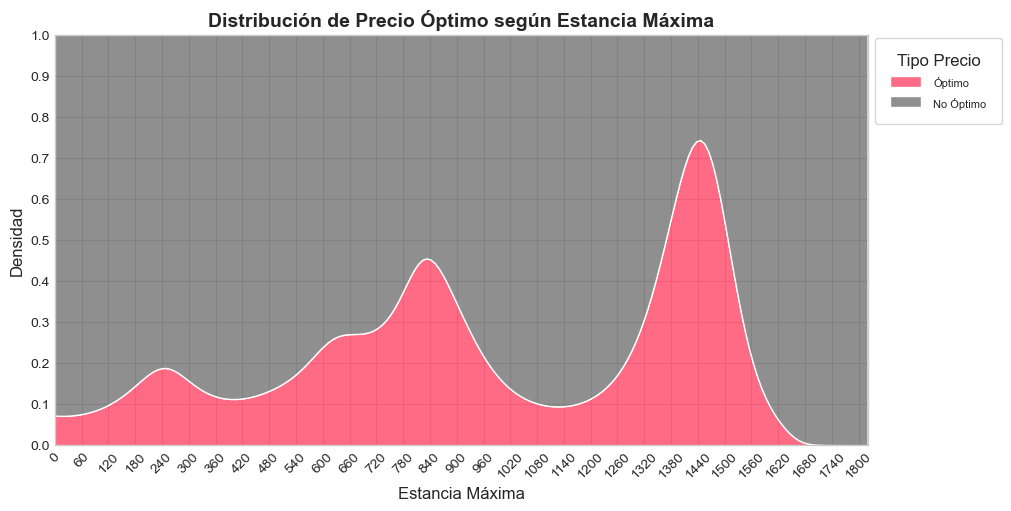

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de maximum nights:
- 1125.0: 59.74% del total
- 30.0: 5.97% del total
- 999.0: 3.05% del total


Maximum Nights % Distribución Óptimos
72            1125                 59.74%
23              30                  5.97%
66             999                  3.05%
71            1124                  3.05%
33              60                  2.79%
39              90                  2.21%
58             365                  2.14%
2                3                  1.23%
14              15                   1.1%
9               10                   1.1%

In [32]:
# Crear una copia del DataFrame sin NaN en maximum_nights
df_max_nights = df.dropna(subset=["maximum_nights"]).copy()
df_max_nights["maximum_nights"] = df_max_nights["maximum_nights"].astype(int)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Gráfico KDE con ajuste de suavidad y evitando valores negativos
sns.kdeplot(
    data=df_max_nights,
    x="maximum_nights",
    hue="precio_optimo",
    multiple="fill",
    palette=palette_airbnb,
    ax=ax,
    clip=(0, 1820) 
)

# Títulos y etiquetas en castellano
ax.set_title("Distribución de Precio Óptimo según Estancia Máxima", fontsize=14, fontweight="bold")
ax.set_xlabel("Estancia Máxima", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use intervalos de 60 en 60
ax.set_xticks(np.arange(0, 1821, 60))
ax.set_xlim(0, 1820)

# Ajustar el eje Y
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Rotar etiquetas del eje X para mejor visibilidad
ax.tick_params(axis="x", rotation=45)

# Leyenda
leg = ax.legend(
    title="Tipo Precio",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Calcular el porcentaje de pisos con precio óptimo por máximo de noches
distribucion_optimos = (
    df_max_nights[df_max_nights["precio_optimo"] == True]
    .groupby("maximum_nights")["precio_optimo"]
    .count()
    .div(df_max_nights["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Maximum Nights", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar los valores con mayor concentración de precios óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de maximum nights:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Maximum Nights']}: {row['% Distribución Óptimos']:.2f}% del total")

# Convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios.sort_values(by="% Distribución Óptimos", 
                                 ascending=False, 
                                 key=lambda x: x.str.rstrip('%').astype(float)).head(10)


## <span style="color: #ff385c;"> ¿Cómo afecta la política de cancelación al precio óptimo?</span>

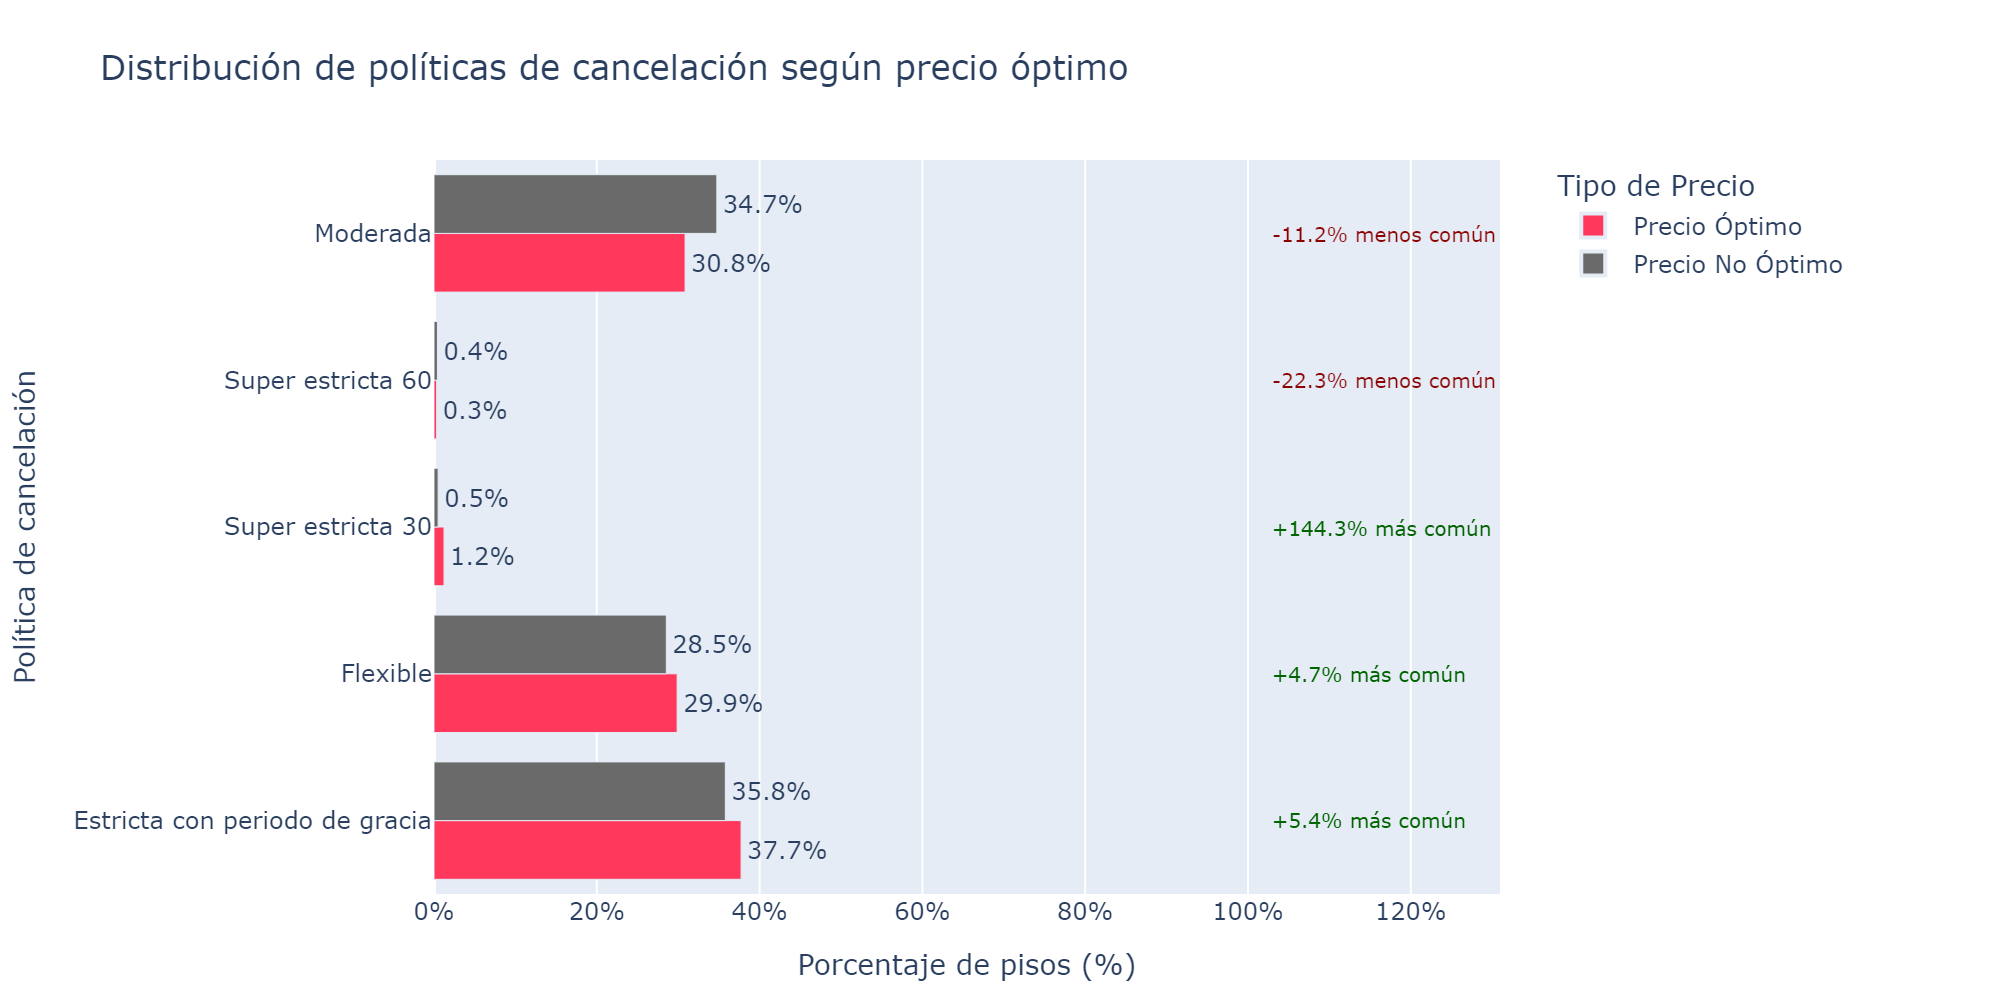

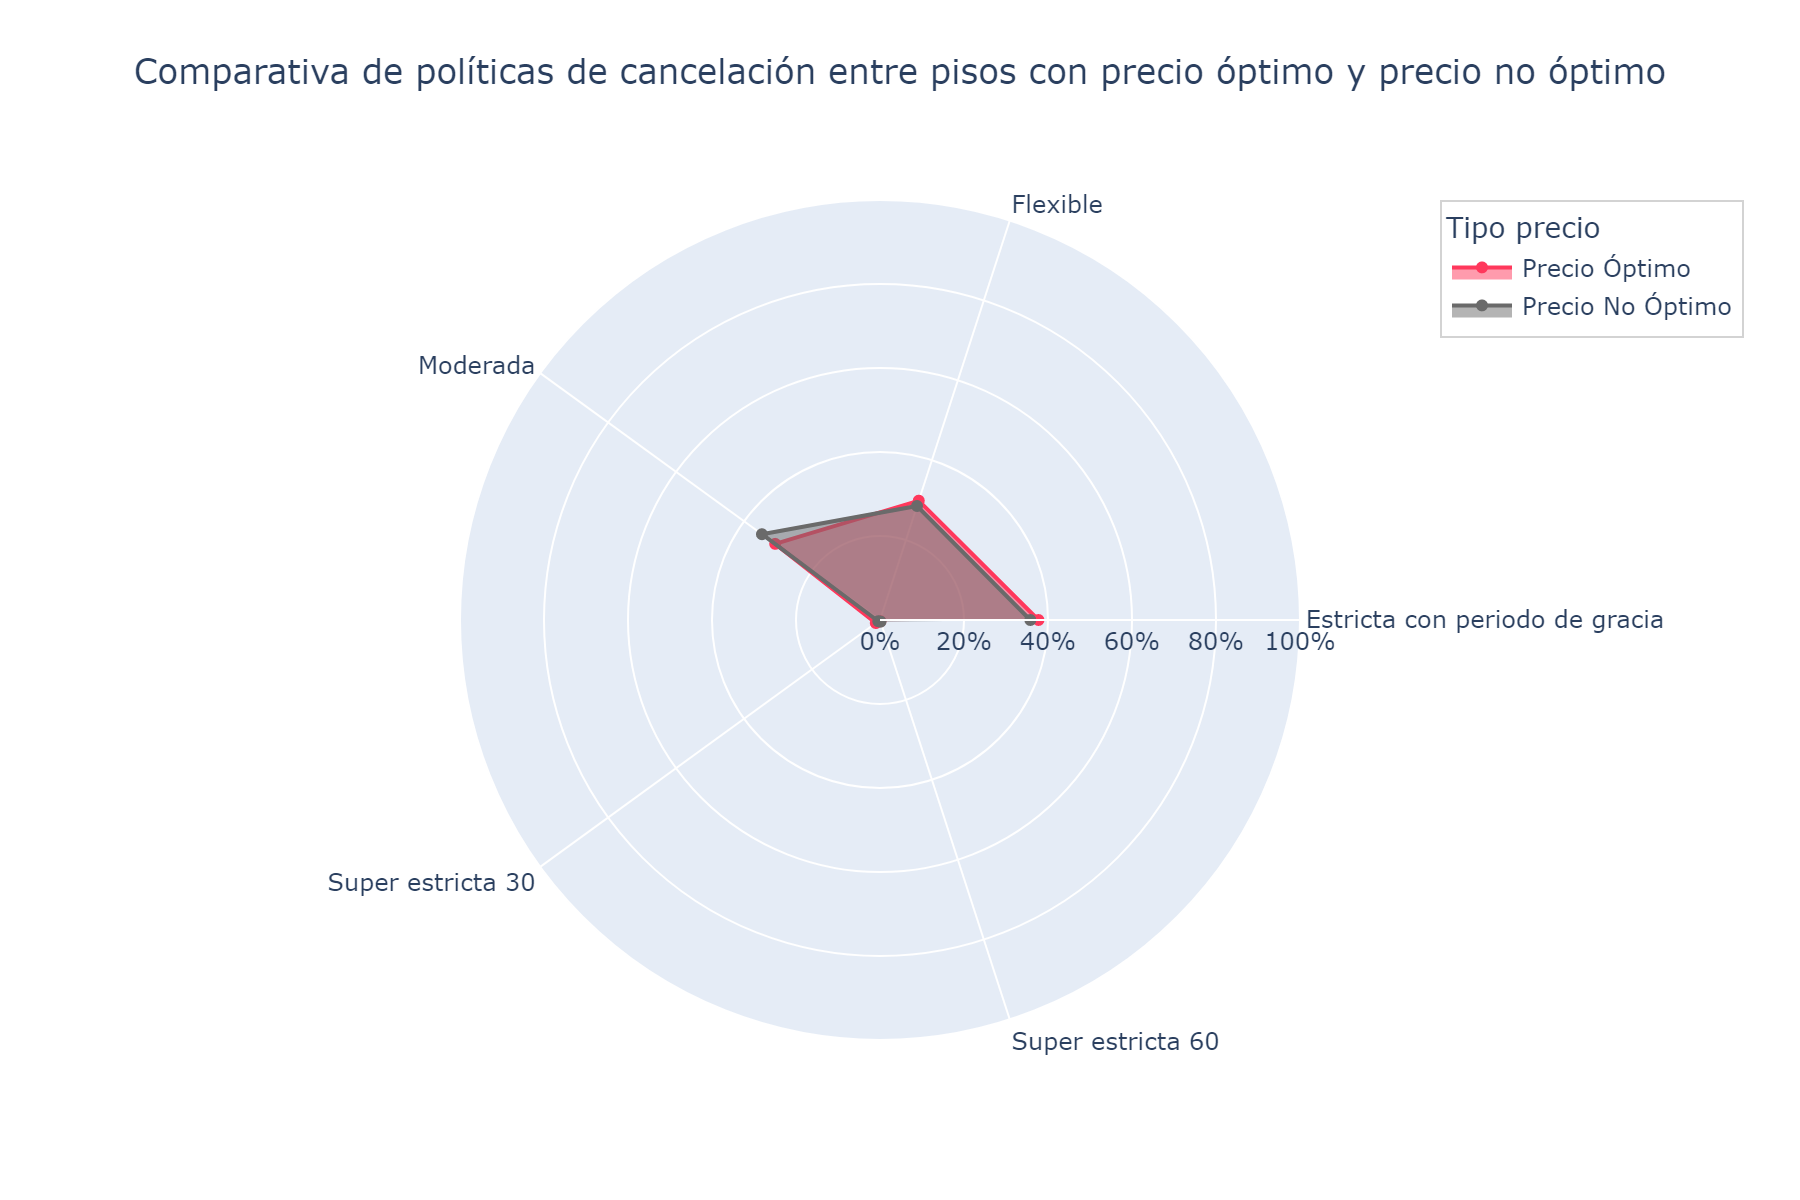

In [33]:
# Crear variables dummies para cancellation_policy
df_cancel_dummies = pd.get_dummies(df["cancellation_policy"], prefix="cancellation")

# Calcular el porcentaje de pisos según la política de cancelación
df_cancel_stats = df[["precio_optimo"]].join(df_cancel_dummies).groupby("precio_optimo", as_index=False).mean()

# Transformar los datos para la visualización
df_cancel_stats = (
    df_cancel_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "cancellation_policy", "value": "porcentaje"})
)

# Mejorar los nombres de las categorías y traducirlos al español
nombre_cancel_policy = {
    "cancellation_flexible": "Flexible",
    "cancellation_moderate": "Moderada",
    "cancellation_strict_14_with_grace_period": "Estricta con periodo de gracia",
    "cancellation_super_strict_30": "Super estricta 30",
    "cancellation_super_strict_60": "Super estricta 60"
}

df_cancel_stats["cancellation_policy_nombre"] = df_cancel_stats["cancellation_policy"].map(nombre_cancel_policy)

# Calcular diferencia porcentual
pivot_df = df_cancel_stats.pivot(index="cancellation_policy", columns="precio_optimo", values="porcentaje").reset_index()
pivot_df["diferencia"] = pivot_df[True] - pivot_df[False]
pivot_df["diferencia_porcentual"] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_cancel_stats,
    pivot_df[["cancellation_policy", "diferencia", "diferencia_porcentual"]],
    on="cancellation_policy"
)

# Ordenar por la diferencia
top_policies = pivot_df.sort_values("diferencia", ascending=False)["cancellation_policy"].tolist()
df_final["cancellation_policy_orden"] = pd.Categorical(df_final["cancellation_policy"], categories=top_policies, ordered=True)

# Crear un mapeo para los valores de precio_optimo
precio_optimo_map = {
    True: "Precio Óptimo",
    False: "Precio No Óptimo"
}

# Aplicar el mapeo
df_final["tipo_precio"] = df_final["precio_optimo"].map(precio_optimo_map)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values("cancellation_policy_orden"),
    y="cancellation_policy_nombre",
    x="porcentaje",
    color="tipo_precio",  # Ahora usamos la columna mapeada
    barmode="group",
    title="Distribución de políticas de cancelación según precio óptimo",
    labels={
        "porcentaje": "Porcentaje de pisos (%)",
        "cancellation_policy_nombre": "Política de cancelación",
        "tipo_precio": "Tipo precio"  # Cambiamos el título de la leyenda
    },
    category_orders={"tipo_precio": ["Precio Óptimo", "Precio No Óptimo"]},  # Orden personalizado
    text_auto=".1%",
    color_discrete_sequence=custom_palette
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text='Tipo de Precio',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.05,
        traceorder='normal',
        itemsizing='constant'
    ),
    xaxis=dict(tickformat='.0%'),
    margin=dict(t=80, b=40, r=250),
    height=500,
    width=1000
)

fig.update_traces(textposition="outside")

# Anotaciones con diferencias porcentuales
for i, policy in enumerate(top_policies):
    subset = df_final[df_final["cancellation_policy"] == policy]
    diff_pct = subset["diferencia_porcentual"].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_cancel_policy[policy]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = "darkgreen" if diff_pct > 0 else "darkred"

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor="left",
            yanchor="middle",
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align="left",
            xshift=10
        )

fig.show()

# Gráfico de radar - También actualizamos para usar los nombres traducidos
radar_df = df_cancel_stats.pivot(index="precio_optimo", columns="cancellation_policy_nombre", values="porcentaje").reset_index()

fig_radar = go.Figure()

# Usamos el mapeo para los nombres en la leyenda
for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df["precio_optimo"] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = precio_optimo_map[precio]  # Usamos el mapeo aquí
        color = '#ff385c' if precio else '#6a6a6a'
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill="toself",
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat=".0%"
        )
    ),
    title={
        "text": "Comparativa de políticas de cancelación entre pisos con precio óptimo y precio no óptimo",
        "y": 0.95,
        "x": 0.5
    },
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.1,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="lightgray",
        borderwidth=1,
        title="Tipo precio"  # Añadimos título a la leyenda del radar
    ),
    margin=dict(r=100),
    height=600,
    width=900
)

fig_radar.show()

fig.write_image("docs/comparativa_cancel_precio.png", scale=2)
fig_radar.write_image("docs/comparativa_cancel_precio_radar.png", scale=2)
display(Image(filename="docs/comparativa_cancel_precio.png"))
display(Image(filename="docs/comparativa_cancel_precio_radar.png"))

# <span style="color: #ff385c;"> 6. Análisis de reseñas de clientes</span>

                    Métrica  Correlación
0                 Ubicación     0.130201
1                  Limpieza     0.081775
2           Puntaje General     0.062995
3                 Precisión     0.041570
4              Comunicación     0.018344
5                  Check-in     0.006273
6         Número de Reseñas    -0.018780
7           Reseñas por Mes    -0.031364
8  Días desde Última Reseña    -0.083212


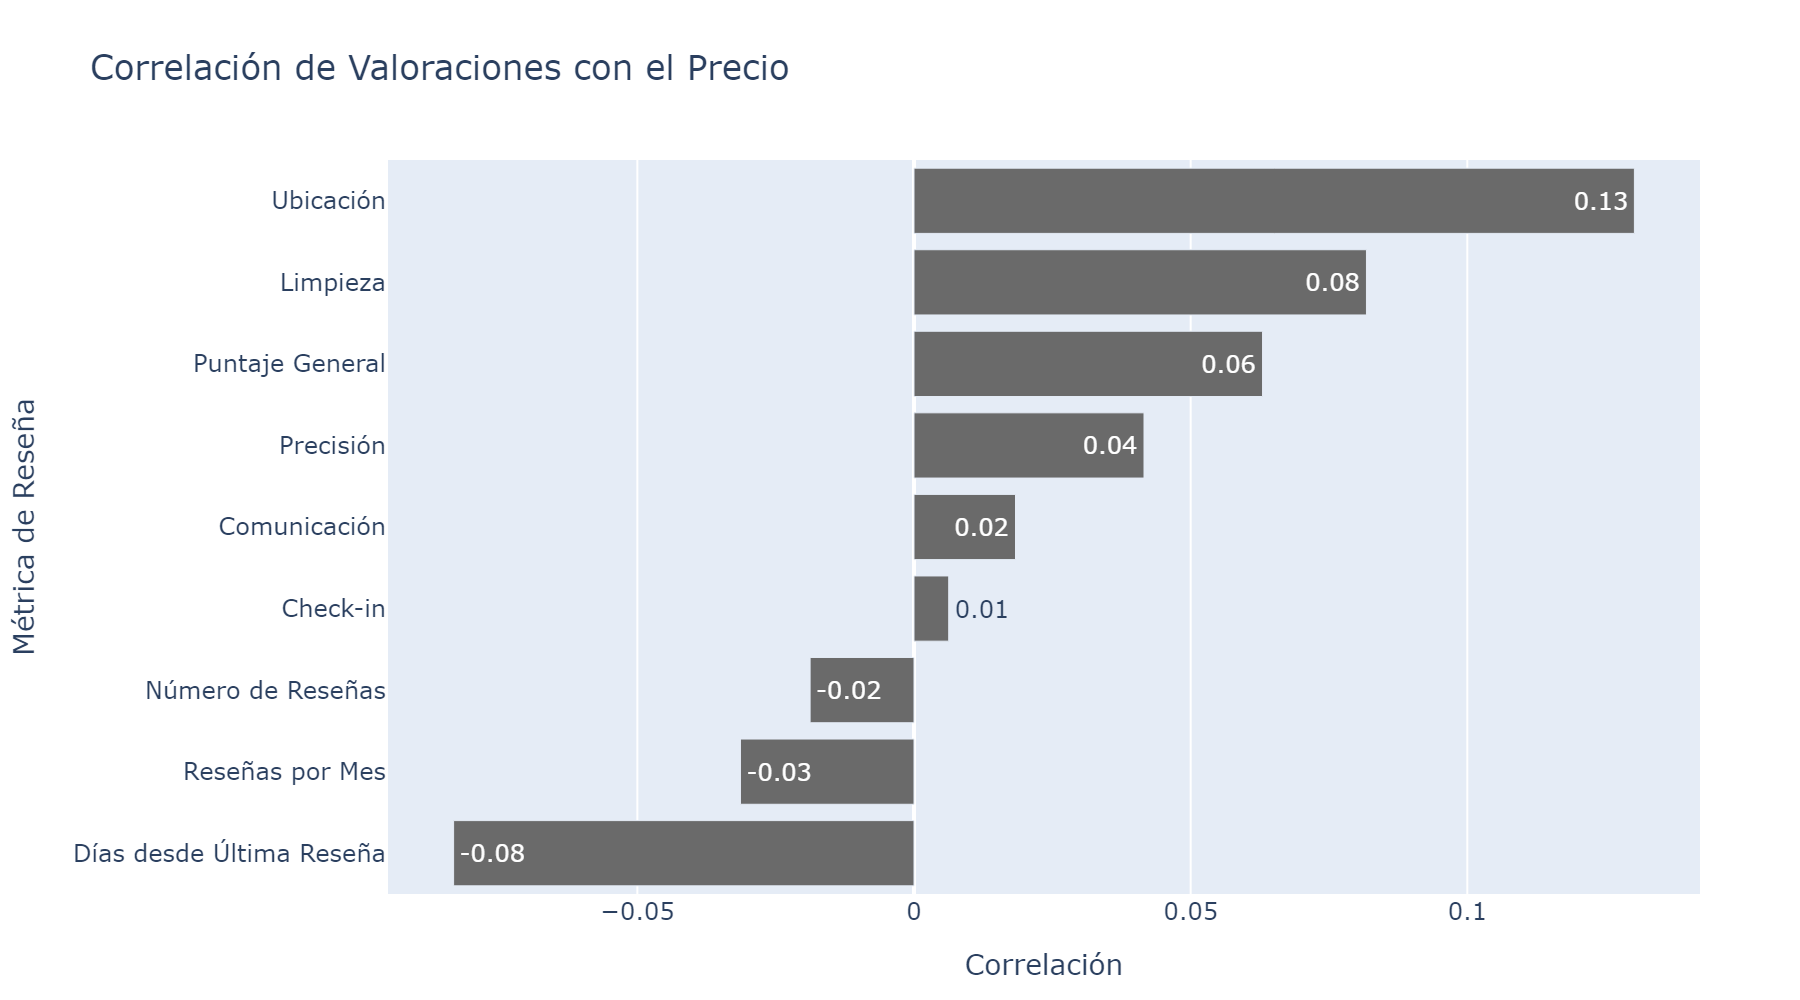

In [34]:
# Definir las variables de reseñas
valoraciones = [
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'days_since_last_review', 'reviews_per_month'
]

# Crear un nuevo DataFrame para análisis sin afectar el original
df_reviews_analysis = df.copy()

# Manejo de NaN en variables de reseñas
df_reviews_analysis['days_since_last_review'] = df_reviews_analysis['days_since_last_review'].fillna(999)
df_reviews_analysis['reviews_per_month'] = df_reviews_analysis['reviews_per_month'].fillna(0)

# Rellenar NaN en puntajes con la mediana
for col in valoraciones:
    df_reviews_analysis[col] = df_reviews_analysis[col].fillna(df_reviews_analysis[col].median())

# Calcular correlaciones con el precio óptimo
correlaciones = df_reviews_analysis[valoraciones + ['price']].corr()['price'].drop('price').sort_values(ascending=False)

# Convertir a DataFrame para visualización
df_correlaciones = correlaciones.reset_index()
df_correlaciones.columns = ['Métrica', 'Correlación']
df_correlaciones['Métrica'] = df_correlaciones['Métrica'].replace({
    'number_of_reviews': 'Número de Reseñas',
    'review_scores_rating': 'Puntaje General',
    'review_scores_accuracy': 'Precisión',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Check-in',
    'review_scores_communication': 'Comunicación',
    'review_scores_location': 'Ubicación',
    'days_since_last_review': 'Días desde Última Reseña',
    'reviews_per_month': 'Reseñas por Mes'
})

# Gráfico de barras
fig = px.bar(
    df_correlaciones.sort_values('Correlación', ascending=True),
    x='Correlación',
    y='Métrica',
    title='Correlación de Valoraciones con el Precio',
    labels={'Correlación': 'Correlación', 'Métrica': 'Métrica de Reseña'},
    text_auto='.2f',
    color_discrete_sequence=palette_airbnb
)

fig.update_layout(
    margin=dict(t=80, b=40, r=50),
    height=500,
    width=900
)

fig.show()

# Mostrar la tabla con las correlaciones ordenadas
print(df_correlaciones)

fig.write_image("docs/correlaciones_reviews.png", scale=2)

display(Image(filename="docs/correlaciones_reviews.png"))


# <span style="color: #ff385c;"> 7. Análisis del host</span>

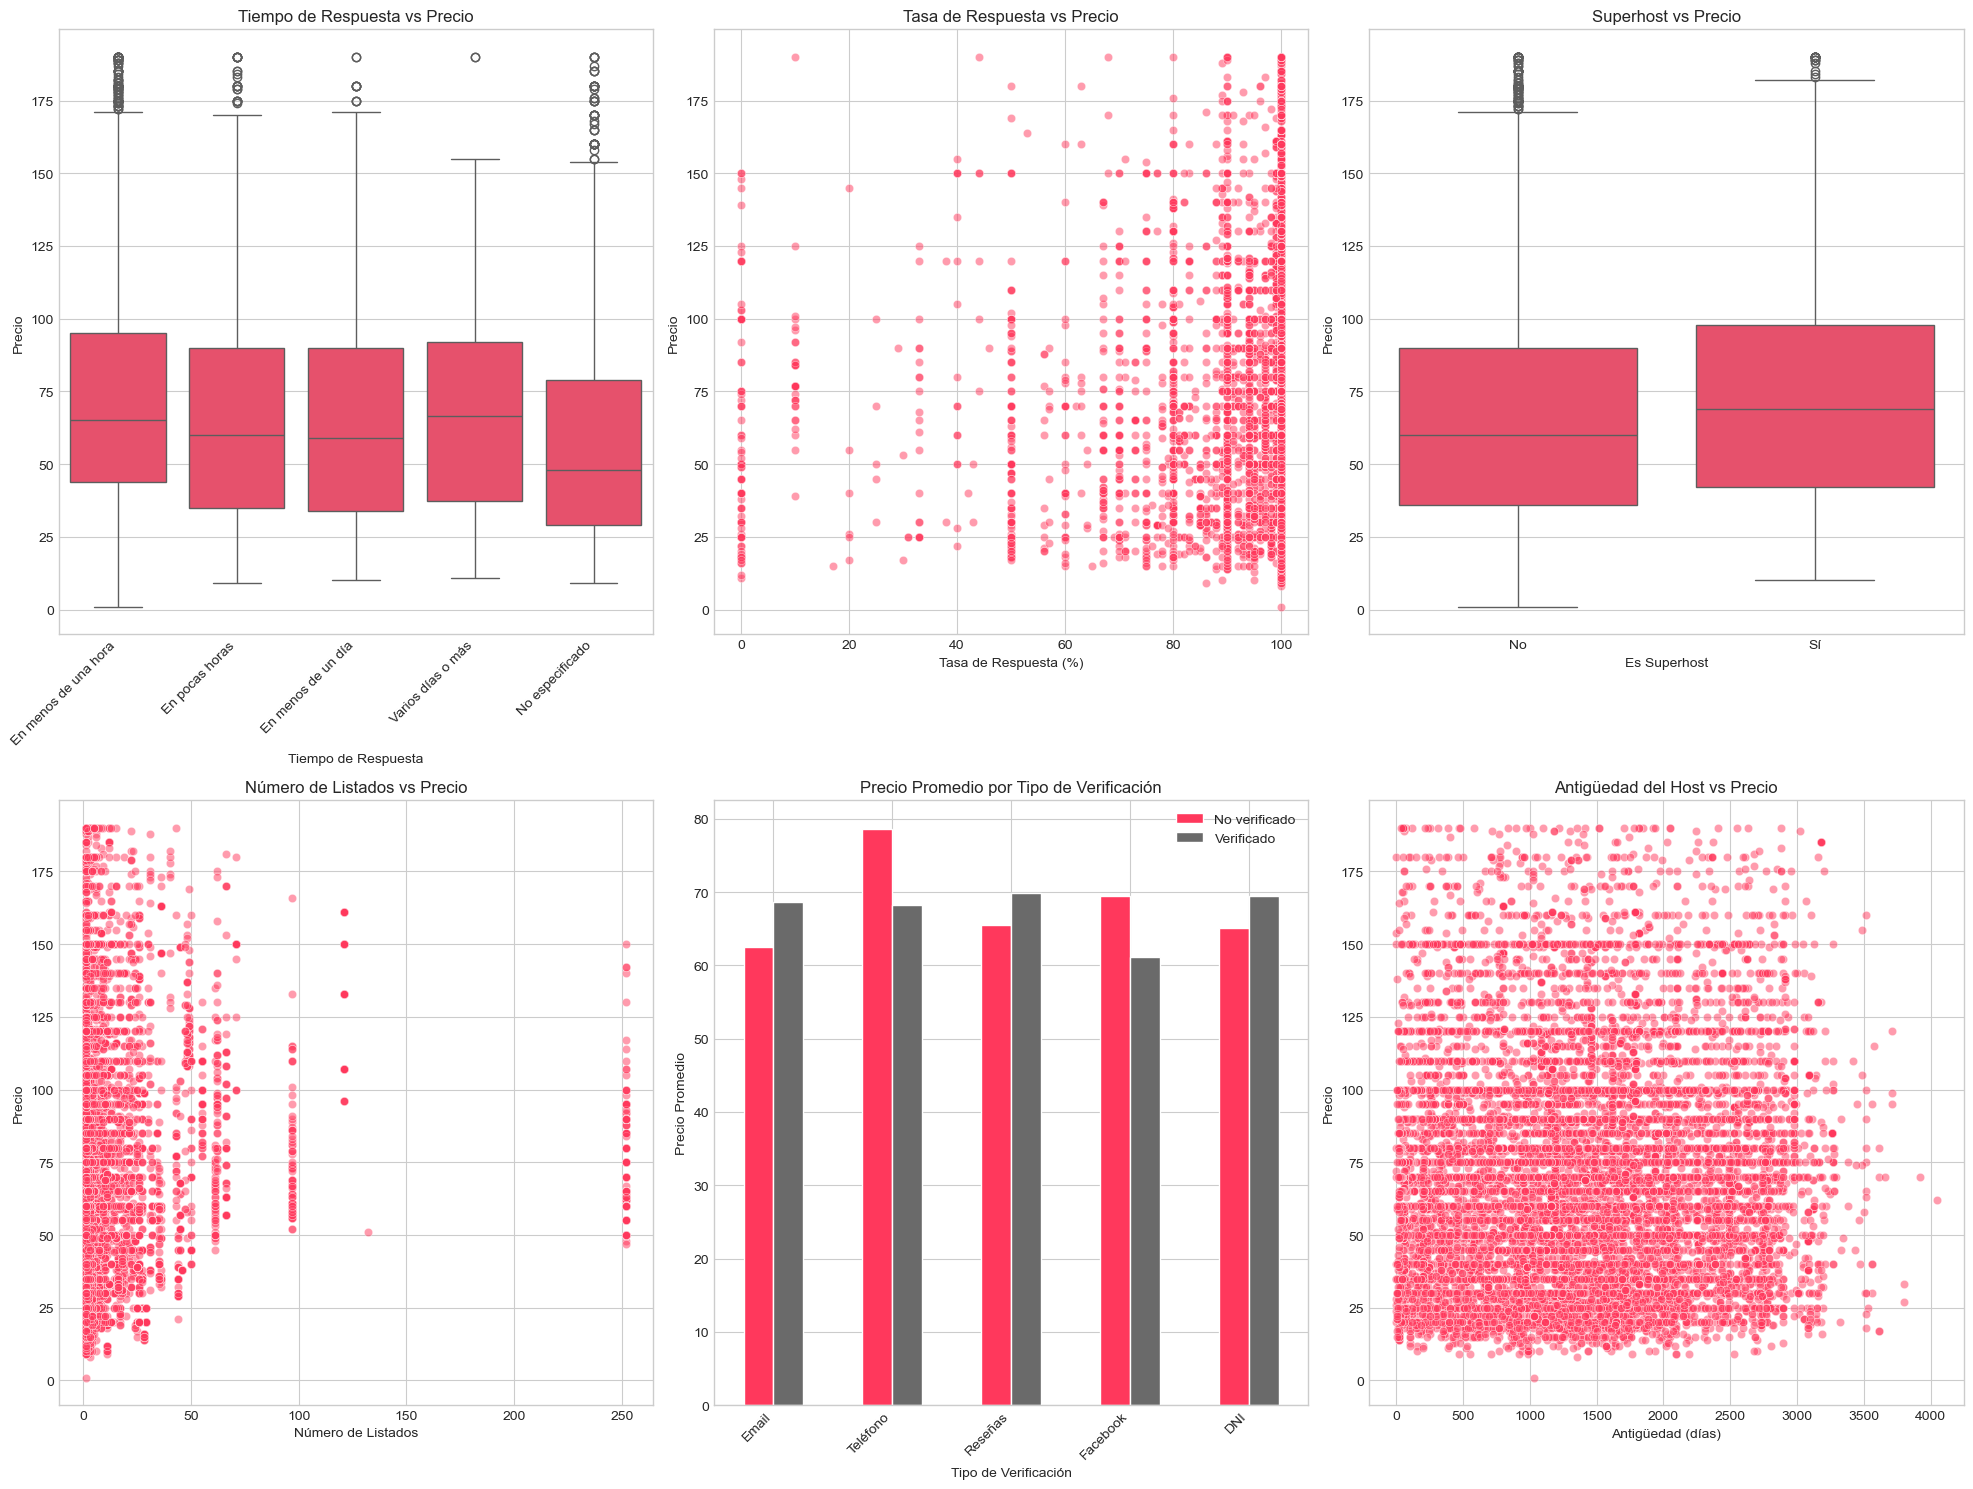

In [40]:
def visualize_host_features(df):
    # Configuración de la figura
    plt.figure(figsize=(20, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    tiempo_respuesta_map = {
        'within_an_hour': 'En menos de una hora',
        'within_a_few_hours': 'En pocas horas',
        'within_a_day': 'En menos de un día',
        'a_few_days_or_more': 'Varios días o más',
        None: 'No especificado'
    }
    
    df_plot = df.copy()
    df_plot['host_response_time_es'] = df_plot['host_response_time'].map(tiempo_respuesta_map)
    
    orden_tiempo_respuesta = [
        'En menos de una hora',
        'En pocas horas',
        'En menos de un día',
        'Varios días o más',
        'No especificado'
    ]
    
    df_plot['host_response_time_es'] = pd.Categorical(
        df_plot['host_response_time_es'], 
        categories=orden_tiempo_respuesta, 
        ordered=True
    )
    
    # 1. Tiempo de Respuesta vs Precio 
    plt.subplot(2, 3, 1)
    sns.boxplot(x='host_response_time_es', y='price', data=df_plot)
    plt.title('Tiempo de Respuesta vs Precio')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Tiempo de Respuesta')
    plt.ylabel('Precio')
    
    # 2. Tasa de Respuesta vs Precio
    plt.subplot(2, 3, 2)
    sns.scatterplot(x='host_response_rate', y='price', data=df_plot, alpha=0.5)
    plt.title('Tasa de Respuesta vs Precio')
    plt.xlabel('Tasa de Respuesta (%)')
    plt.ylabel('Precio')
    
    # 3. Superhost vs Precio
    plt.subplot(2, 3, 3)
    sns.boxplot(x='host_is_superhost', y='price', data=df_plot)
    plt.title('Superhost vs Precio')
    plt.xlabel('Es Superhost')
    plt.ylabel('Precio')
    plt.xticks([0, 1], ['No', 'Sí'])
    
    # 4. Número de Listados vs Precio
    plt.subplot(2, 3, 4)
    sns.scatterplot(x='calculated_host_listings_count', y='price', data=df_plot, alpha=0.5)
    plt.title('Número de Listados vs Precio')
    plt.xlabel('Número de Listados')
    plt.ylabel('Precio')
    
    # 5. Verificaciones del Host
    verificaciones = [
        'host_verifications_email',
        'host_verifications_phone',
        'host_verifications_reviews',
        'host_verifications_facebook',
        'host_verifications_government_id'
    ]
    
    nombre_verificaciones = {
        'host_verifications_email': 'Email',
        'host_verifications_phone': 'Teléfono',
        'host_verifications_reviews': 'Reseñas',
        'host_verifications_facebook': 'Facebook',
        'host_verifications_government_id': 'DNI'
    }
    
    plt.subplot(2, 3, 5)
    verificacion_prices = {}
    for ver in verificaciones:
        verificacion_prices[nombre_verificaciones[ver]] = df_plot.groupby(ver)['price'].mean()
    
    verificacion_df = pd.DataFrame.from_dict(verificacion_prices).T
    verificacion_df.columns = ['No', 'Sí']  
    verificacion_df.plot(kind='bar', ax=plt.gca())
    plt.title('Precio Promedio por Tipo de Verificación')
    plt.xlabel('Tipo de Verificación')
    plt.ylabel('Precio Promedio')
    plt.xticks(rotation=45, ha='right')
    plt.legend(['No verificado', 'Verificado'])
    
    # 6. Distribución de la Antigüedad del Host
    plt.subplot(2, 3, 6)
    sns.scatterplot(x='host_seniority', y='price', data=df_plot, alpha=0.5)
    plt.title('Antigüedad del Host vs Precio')
    plt.xlabel('Antigüedad (días)')
    plt.ylabel('Precio')
    plt.tight_layout()
    plt.show()

visualize_host_features(df)